# Project One

## 1. Introduction

# What Attributes Determine a Yelp rating in the United States?

This analytical paper contains data from the *Yelp Dataset* published by Yelp and accessed through Kaggle. The Y variable studied is the Yelp rating restaurants receive, in relation to five X variables analyzed in this report: 
the number of reviews a restaurant receives, the city the restaurant is located in, the number of check-ins a restaurant has recorded, and the category value that a restaurant is associated with. 


The number of reviews a restaurant receives is of interest because it could be the case that more popular restaurants receive more reviews, but the ratings may reflect otherwise. Whether more reviews indicate higher-rated restaurants is of interest. The number of check-ins a restaurant has received is studied to determine whether eagerness to report a check-in would correlate with higher ratings. The category items that a restaurant is associated with are analyzed to determine whether certain cuisines or keywords are predictive of the type of rating a restaurant may receive. The city a restaurant is located is examined to determine whether the geographical location of a restaurant is a determinant of the kind of rating a restaurant may receive. Location may encompass many more factors such as differences in economic status, culture, food preference, and demographic differences in general. Later in this paper, external datasets from the US Census Bureau regarding personal income, the median age of first marriage, and family size are merged with the Yelp Dataset to explore these factors on a geographic level. 


Based on the summaries of the Yelp Dataset, a number of correlations can be made regarding restaurant attributes and their Yelp rating. A positive relationship seems to exist between the number of reviews a restaurant receives and the rating they received. The category a restaurant falls under appears to be significantly linked to the rating they can expect to receive where more sit-down environments such as cafes receive higher ratings on average in comparison to on-the-go environments such as fast food or burger joints. The geographic location of a restaurant seems to hold some significance whereas restaurants in European cities tend to have higher restaurant ratings. Restaurants, where users have checked in more, are positively correlated with a greater rating. Upon summarizing the average restaurant ratings across states in the US based on the number of establishments and reviews, there appears to be a greater number of restaurants and reviews for states in the middle of the range for ratings. When honing in on the restaurants in the US with ratings above 4.5 stars, there appears to be a difference across the states regarding the ratio of restaurants with ratings above 4.5 stars out of all restaurants in the respective state.

In the latter portion of this paper, further analysis of data for restaurants in the US at the state geographical level is conducted using data regarding the personal income of people residing in different states, and implementing data from the *American Community Survey* for 2021 published by the US Census Bureau regarding the median marriage age and family size across the US states.

## 2. Data Cleaning/Loading

In [ ]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

In [406]:
# imports
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from shapely.geometry import Point
import seaborn as sns
import plotly.graph_objects as go 
import plotly.offline as pyo
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS
import re
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree

%matplotlib inline
# import geodataframe as gdf

import requests

import geopandas as gpd
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')


In [2]:
# datasets
df_business = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_business.csv'))
df_tip = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_tip.csv'))
df_attributes = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_business_attributes.csv'))
df_hours = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_business_hours.csv'))
df_checkin = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_checkin.csv'))
df_user = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_user.csv'))

### Data Cleaning for Users

In [3]:
df2_user = df_user.copy()
df2_user = df2_user.drop(columns=['friends', 'useful', 'funny', 'cool', 'fans', 'elite', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer', 'compliment_photos', 'compliment_hot'])
df2_user.head(10)

,user_id,name,review_count,yelping_since,average_stars
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,3.70
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,2.00
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,2015-03-13,4.67
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,2016-09-08,4.67
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,2012-07-16,3.45
5,Ob-2oGBQ7rwwYwUvhmnf7g,B,9,2012-05-01,4.78
6,JaTVvKsBl0bHHJEpESn4pQ,Peter,2,2013-03-23,5.00
7,Ykj0DVsz0c6rX9ghjd0hDg,Colleen,1,2010-10-10,1.00
8,kmyEPfKnHQJdTceCdoyMQg,A,7,2012-10-16,4.29
9,H54pA7YHfjl8IjhHAfdXJA,Chad,3,2010-06-25,5.00


A clean copy of user data with columns removed because most users have no data recorded in those columns. The 'user_id' column contains the unique ID for each Yelp reviewer and contains the information of the other columns in the df2_users dataframe. The 'name' column contains the name the reviewer has indicated, the 'review_count' column indicates the total number of reviews the reviewer has written, the 'yelping_since' column indicates the date the Yelp user registered, and the 'average_stars' column indicates the average star rating the reviewer typically writes. 

### Data Cleaning for Businesses

In [3]:
df2_business = df_business.copy()
id_drops = []
for i in df2_business.index:
    if "Restaurants" not in df2_business['categories'][i] or df2_business['is_open'][i] != 1:
        id_drops.append(df2_business['business_id'][i])
    else:
        df2_business['categories'][i] = df_business['categories'][i].split(";")

df2_business = df2_business[df2_business.business_id.isin(id_drops) == False]

In [4]:
for i in df2_business['city'].index:
    df2_business['city'][i] = df2_business['city'][i].capitalize()
df2_business.head(10)

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga falls,OH,44221,41.119535,-81.475690,3.5,116,1,"[American (New), Nightlife, Bars, Sandwiches, ..."
5,o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",NaN,"""Richterstr. 11""",Stuttgart,BW,70567,48.727200,9.147950,4.0,5,1,"[Italian, Restaurants]"
14,fNMVV_ZX7CJSDWQGdOM8Nw,"""Showmars Government Center""",Uptown,"""600 E 4th St""",Charlotte,NC,28202,35.221647,-80.839345,3.5,7,1,"[Restaurants, American (Traditional)]"
19,Gu-xs3NIQTj3Mj2xYoN2aw,"""Maxim Bakery & Restaurant""",NaN,"""9665 Bayview Avenue, Unit 1-4""",Richmond hill,ON,L4C 9V4,43.867565,-79.412662,3.5,34,1,"[French, Food, Bakeries, Restaurants]"
25,1K4qrnfyzKzGgJPBEcJaNQ,"""Chula Taberna Mexicana""",Leslieville,"""1058 Gerrard Street E""",Toronto,ON,M4M 3A6,43.669256,-79.335902,3.5,39,1,"[Tiki Bars, Nightlife, Mexican, Restaurants, B..."
28,Dj0S-Oe4ytRJzMGUPgYUkw,"""Panera Bread""",NaN,"""38295 Chestnut Ridge Rd""",Elyria,OH,44035,41.343078,-82.067140,2.0,4,1,"[Soup, Salad, Sandwiches, Restaurants]"
30,nbhBRhZtdaZmMMeb2i02pg,"""Sunnyside Grill""",NaN,"""2777 Steeles Avenue W""",Toronto,ON,M3J 3K5,43.781816,-79.490433,5.0,3,1,"[Restaurants, Breakfast & Brunch]"
33,FXHfcFVEfI1vVngW2gVOpw,"""Bampot House of Tea & Board Games""",NaN,"""201 Harbord Street""",Toronto,ON,M5S 1H6,43.661582,-79.408878,4.0,55,1,"[Coffee & Tea, Restaurants, Food, Mediterranea..."
40,tRVx2c89coruPRwYhGTcTw,"""Yuzu""",NaN,"""13603 Madison Ave""",Lakewood,OH,44107,41.476846,-81.786971,3.5,78,1,"[Nightlife, Izakaya, Comfort Food, Cocktail Ba..."
45,rDMptJYWtnMhpQu_rRXHng,"""McDonald's""",NaN,"""719 E Thunderbird Rd""",Phoenix,AZ,85022,33.607070,-112.064382,1.0,10,1,"[Fast Food, Burgers, Restaurants]"


A clean copy of the business data which filters for businesses that are restaurants and capitalizes all the city names. The first column, 'business_id' contains the unique ID's for the restaurants on Yelp. The other columns in the df_business dataframe contain the specific details for each restaurant. The 'name' column specifies the name of the restaurant. The 'neighborhood', 'address', 'city', 'state', 'postal_code', 'latitude', and 'longitutde' columns all specify the location of the respective restaurants. The 'stars' column specifies the star rating the restaurants receive on Yelp, the 'review_count' column indicates the total amount of reviews the restaurants have recieved, and the 'categories' column contains the keywords these restaurants are labelled with. 

### Data Cleaning for Yelp Reviews

In [16]:
df2_tip = df_tip.copy()
df2_business_tip = df2_business[['business_id', 'name', 'stars']]
df2_tip = df2_tip[df2_tip.business_id.isin(id_drops) == False]
df2_tip = pd.merge(df2_business_tip, df2_tip, on='business_id').drop(['business_id', 'likes'], axis = 1)

df2_tip.head(10)

,name,stars,text,date,user_id
0,"""Brick House Tavern + Tap""",3.5,People are giving this place 1 star because of...,2013-02-19,8v1rpTH0d8YjjGWA892l1Q
1,"""Brick House Tavern + Tap""",3.5,"Excellent selection of beers on tap, many scre...",2013-05-11,y_RCzjU-K_KrMBko3mMhsg
2,"""Brick House Tavern + Tap""",3.5,Great event held by yelp!! Will be back!!,2012-10-15,3OhkexT0E78zylIH426EOg
3,"""Brick House Tavern + Tap""",3.5,I love this place. They always take good care ...,2012-01-18,RgTByLRNRTJNmeWgp6Kg4Q
4,"""Brick House Tavern + Tap""",3.5,Chop Steak was surprisingly good. Love love lo...,2011-09-29,RgTByLRNRTJNmeWgp6Kg4Q
5,"""Brick House Tavern + Tap""",3.5,Good beer and even better food,2016-02-18,EAfLAFYv46w2SCvgN_m_VQ
6,"""Brick House Tavern + Tap""",3.5,Go!!,2014-08-06,yTIQesfMFpf038iEFx1keQ
7,"""Brick House Tavern + Tap""",3.5,"Try the Mac and Cheese, it's the best I have e...",2012-11-26,EaCzl3GqLvbq-IO3yOrm6g
8,"""Brick House Tavern + Tap""",3.5,So many beers on tap and huge snack menu. Week...,2017-09-29,4s_zxWFUqW6-TKYMPYUOiQ
9,"""Brick House Tavern + Tap""",3.5,"Beautiful women, great food and spirits.",2012-03-04,Er7va1rRXiQVVcz2LOwXKg


In [127]:
len(df2_tip)

584366

This dataframe illustrates a clean copy of the data in the 'yelp_tip' csv file where the business names are merged with the a user's review based on the 'business_id' of restaurants. The 'name' column specifies which restaurant has received the specific review. The 'stars' column indicates the number of stars that a user has given to a restaurant, the 'text' column contains the review comments that a user left, 'date' contains when a review was written and the 'user_id' column attaches the unique user's ID to the review they have written. 

### Data Cleaning for Attributes

In [122]:
df2_attributes = df_attributes.copy()
df2_business_attributes = df2_business[['business_id', 'name', 'stars']]
df2_attributes = df2_attributes[df2_attributes.business_id.isin(id_drops) == False]
df2_attributes = df2_attributes.drop(columns=['AcceptsInsurance', 'ByAppointmentOnly', 'HairSpecializesIn_coloring', 'HairSpecializesIn_africanamerican', 'HairSpecializesIn_curly', 'HairSpecializesIn_perms', 'HairSpecializesIn_kids', 'HairSpecializesIn_extensions', 'HairSpecializesIn_asian', 'HairSpecializesIn_straightperms', 'Music_dj', 'Music_karaoke', 'GoodForDancing', 'Smoking', 'DogsAllowed', 'BusinessAcceptsBitcoin', 'AgesAllowed' ])
df2_attributes = pd.merge(df2_business_attributes, df2_attributes, on='business_id').drop(['business_id'], axis = 1)
df2_attributes.head(10)

,name,stars,BusinessAcceptsCreditCards,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,RestaurantsPriceRange2,GoodForKids,...,BYOB,Corkage,DietaryRestrictions_dairy-free,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,RestaurantsCounterService
0,"""Brick House Tavern + Tap""",3.5,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
1,"""Messina""",4.0,Na,Na,False,False,False,False,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
2,"""Showmars Government Center""",3.5,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
3,"""Maxim Bakery & Restaurant""",3.5,Na,Na,False,False,False,True,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
4,"""Chula Taberna Mexicana""",3.5,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
5,"""Panera Bread""",2.0,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
6,"""Sunnyside Grill""",5.0,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
7,"""Bampot House of Tea & Board Games""",4.0,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
8,"""Yuzu""",3.5,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
9,"""McDonald's""",1.0,Na,Na,False,False,False,True,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na


This dataframe reflects a clean copy of data from the 'yelp_attributes' csv file by removing attributes that are unrelated to restaurants, and only contains restaurant businesses. Additionally, the restaurant name and star rating from the 'yelp_businesses' dataframe is merged with the 'yelp_attributes' data based on the unique 'business_id' that is associated with each business. The 'name' column indcates the name of the restaurants, and 'stars' contains the number of Yelp stars that a restaurant has recieved. The columns 'BusinessAcceptsCreditCards', 'BusinessParking_garage', 'BusinessParking_street', 'BusinessParking_validated', 'BusinessParking_lot', 'BusinessParking_valet', and 'GoodForKids' provide information on the payment method available, the convenience of parking, and whether the environment is suitable for children. The columns 'BYOB', 'Corkage', 'DietaryRestrictions_dairy-free', 'DietaryRestrictions_gluten-free', 'DietaryRestrictions_vegan','DietaryRestrictions_kosher', 'DietaryRestrictions_halal', 'DietaryRestrictions_soy-free', 'DietaryRestrictions_vegetarian', and 'RestaurantsCounterService' contain information pertaining to the dietary accessibility of a restaurant.  

### Data Cleaning for Business Hours

In [124]:
df2_hours = df_hours.copy()
df2_business_hours = df2_business[['business_id', 'name', 'stars']]
df2_hours = df2_hours[df2_hours.business_id.isin(id_drops) == False]

# clean restaurants with no business hours any day
no_hours = []
for i in df2_hours.index:
    if df2_hours['monday'][i] == df2_hours['tuesday'][i] == df2_hours['wednesday'][i] == df2_hours['thursday'][i] == df2_hours['friday'][i] == df2_hours['saturday'][i] == df2_hours['sunday'][i] == 'None':
        no_hours.append(i)

df2_hours.drop(no_hours, axis=0, inplace=True)

#clean data for opening and closing hours 
days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

for col in days:
    df2_hours[[col+'_open', col+'_close']] = df2_hours[col].apply(lambda x: pd.Series(str(x).split('-')))

df2_hours = df2_hours.drop(days, axis=1)
df2_hours = pd.merge(df2_business_hours, df2_hours, on='business_id').drop(['business_id'], axis = 1).fillna('0:0')

df2_hours.head(10)


,name,stars,monday_open,monday_close,tuesday_open,tuesday_close,wednesday_open,wednesday_close,thursday_open,thursday_close,friday_open,friday_close,saturday_open,saturday_close,sunday_open,sunday_close
0,"""Brick House Tavern + Tap""",3.5,11:0,1:0,11:0,1:0,11:0,1:0,11:0,1:0,11:0,1:0,11:0,2:0,11:0,0:0
1,"""Messina""",4.0,18:0,0:0,18:0,0:0,18:0,0:0,18:0,0:0,18:0,0:0,18:0,0:0,None,0:0
2,"""Showmars Government Center""",3.5,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0,None,0:0,None,0:0
3,"""Maxim Bakery & Restaurant""",3.5,11:30,22:0,11:30,22:0,11:30,22:0,11:30,22:0,11:30,23:0,11:0,23:0,11:0,22:0
4,"""Chula Taberna Mexicana""",3.5,11:30,2:0,11:30,2:0,11:30,2:0,11:30,2:0,11:30,2:0,10:30,2:0,10:30,2:0
5,"""Panera Bread""",2.0,6:30,21:0,6:30,21:0,6:30,21:0,6:30,21:0,6:30,22:0,7:0,22:0,7:0,20:0
6,"""Sunnyside Grill""",5.0,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0
7,"""Bampot House of Tea & Board Games""",4.0,17:0,23:0,11:0,23:0,11:0,23:0,11:0,23:0,12:0,1:30,12:0,1:30,12:0,23:0
8,"""Yuzu""",3.5,12:0,2:0,12:0,2:0,12:0,2:0,12:0,2:0,12:0,2:0,11:0,2:0,None,0:0
9,"""Charr An American Burger Bar""",3.0,11:0,22:0,11:0,22:0,11:0,22:0,11:0,22:0,11:0,23:0,11:0,23:0,11:0,21:0


This dataframe includes a clean copy of the business hours data where the restaurant opening and closing times for each day are sperated into individual columns. Restaurant names and their rating are matched with their business hours based on their 'business_id'. The 'name' column includes the names of the restaurants, and the 'stars' column specifies the rating the restaurant has recieved on Yelp. The columns 'monday_open', 'tuesday_open', 'wednesday_open', 'thursday_open', 'friday_open', 'saturday_open', and 'sunday_open' indicate the time that the restaurants open on each day of the week. The columns 'monday_close', 'tuesday_close', 'wednesday_close', 'thursday_close',  'friday_close', 'saturday_close', and 'sunday_close' contain the time that the restaurants close on each day of the week. 

### Data Cleaning for Yelp Checkins

In [5]:
df2_checkin = df_checkin.copy()
df2_checkin = df2_checkin[df2_checkin.business_id.isin(id_drops) == False].drop(columns = ['weekday', 'hour']).groupby('business_id')['checkins'].sum()

df2_business_checkin = df2_business[['business_id', 'name', 'review_count', 'stars']]

df2_checkin = pd.merge(df2_checkin, df2_business_checkin, on='business_id')
df2_checkin = df2_checkin.drop(['business_id'], axis = 1)[['name', 'checkins','review_count', 'stars']]

df2_checkin.head(10)

,name,checkins,review_count,stars
0,"""John's Chinese BBQ Restaurant""",139,37,3.0
1,"""Delmonico Steakhouse""",2568,1451,4.0
2,"""Sunnyside Grill""",89,39,3.5
3,"""The Bar At Bermuda & St. Rose""",490,108,3.5
4,"""Mm Mm Pizza""",20,7,4.0
5,"""Happy Moose Bar and Grill""",89,72,3.5
6,"""Hungry Howie's Pizza""",93,12,3.0
7,"""Denny's""",60,28,2.0
8,"""Keung Kee Restaurant""",148,44,3.5
9,"""Pio Pio""",672,317,4.0


This dataframe contains a clean copy of data from the 'yelp_checkins' csv file, and analyzes restaurants by their total number of checkins and the star rating they have recieved. The 'name' column includes the name of the restaurant, the 'checkins' column indicates the total number of checkins a restaurant has received on Yelp, the 'review_count' column includes the number of reviews have been written for a restaurant and the 'stars' column contains the star rating a restaurant has received. 

### Data Cleaning for Real Personal Income in US States in 2021

In [6]:
# importing data for personal income
income_data = pd.read_excel('/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/PI_2021.xlsx')
# changing column names
income_data = income_data.rename(columns={'Unnamed: 1': 'Name', 'Unnamed: 2': 'Personal Income'}).drop(columns=['SARPI Real personal income and real personal Consumption Expenditures (PCE) by state'], axis=1)
# data cleaning for state data for states included in the Yelp Dataset
state_names = ['Arizona', 'Illinois', 'North Carolina', 'Nevada', 'Ohio', 'Pennsylvania', 'South Carolina', 'Wisconsin']
income_data = income_data[income_data.Name.isin(state_names)]

income_data

,Name,Personal Income
8,Arizona,362113.5
19,Illinois,728882.6
34,Nevada,171884.2
39,North Carolina,548116.5
41,Ohio,628659.7
44,Pennsylvania,750118.9
46,South Carolina,252155.0
55,Wisconsin,326703.2


This data cleaning involves importing a dataset describing the real the personal income of citizens in United States. The column 'Name' includes the names of states and the 'Personal Income' column indicates the real personal income in the respective state in millions of dollars with 2012 as the base year.

## 3. Summary Statistic Tables

In [7]:
def get_summary_statistic(df, column):
    result = {column: [], 'total_restaurants': [], 'sum_stars' : [], 'average_stars': []}
    # access the cells
    for i in df.index:
        # check for list condition
        if type(df[column][i]) == list:
            for j in df[column][i]:
                if j not in result[column]:
                    result[column].append(j)
                    result['total_restaurants'].append(1)
                    result['sum_stars'].append(df['stars'][i])
                else:
                    index = result[column].index(j)
                    result['total_restaurants'][index] += 1
                    result['sum_stars'][index] += df["stars"][i]
        else:
            if df[column][i] not in result[column]:
                result[column].append(df[column][i])
                result['total_restaurants'].append(1)
                result['sum_stars'].append(df["stars"][i])
            else:
                index = result[column].index(df[column][i])
                result['total_restaurants'][index] += 1
                result['sum_stars'][index] += df["stars"][i]

    for i in result[column]:
        avg = result['sum_stars'][result[column].index(i)]/result['total_restaurants'][result[column].index(i)]
        result['average_stars'].append(round(avg, 2))

    dataframe = pd.DataFrame(result).sort_values(by='total_restaurants', ascending=False)
    return dataframe

The function above produces a summary statistics data frame which passes in a data frame and a column name to be analyzed. The 'X' variable consists of items in the given column and the 'Y' variable is the average star rating for restaurants that fall under a category in the column. The summary statistic provides the "total_restaurants", which reflects how many restaurants fall under a category item, "sum stars", which reflects the total sum of stars restaurants in the category receive, and "average_stars", which reflects the average star rating a restaurant in that category receives. 

### Summary statistics of reviews and Yelp stars

In [8]:
review_summary_statistic = get_summary_statistic(df2_business.copy(), 'review_count').drop(columns=['sum_stars']).sort_values(by='review_count')

review_summary_statistic.head(15)

,review_count,total_restaurants,average_stars
6,3,3217,3.31
5,4,2125,3.37
1,5,1764,3.34
13,6,1557,3.31
2,7,1380,3.34
22,8,1137,3.34
38,9,1039,3.34
9,10,958,3.27
11,11,850,3.39
52,12,827,3.35


This summary statistic indicates the average star rating for restaurants with a certain number of reviews. The 'review_count' column indicates the number of reviews that restaurants receive and the 'average_stars' column indicates the average star rating that restaurants with that specific number of reviews receive. The summary statistic is ordered by the 'review_count' column going from least to most Yelp restaurant reviews. From this data, it can be observed that more restaurants tend to have lower restaurant review counts compared to higher restaurant review counts. Additionally, the average star rating for restaurants with less reviews tend to have lower average Yelp star ratings which may lead to inferences about the effect of the popularity and reputation of restaurants on higher Yelp ratings. 

### Summary statistics of Category types and Yelp stars

In [9]:
category_summary_statistic = get_summary_statistic(df2_business.copy(), 'categories').drop(columns=['sum_stars', 'total_restaurants']).drop(6).drop(11).drop(9).head(15)
category_summary_statistic.sort_values(by='average_stars')

,categories,average_stars
26,Fast Food,2.85
60,Chicken Wings,2.93
5,Burgers,3.00
36,Pizza,3.35
31,Chinese,3.35
4,American (Traditional),3.36
12,Mexican,3.44
3,Sandwiches,3.46
7,Italian,3.54
1,Nightlife,3.55


This summary statistic reflects a category restaurants indicate in their Yelp descriptions and the average star rating for restaurants that fall under the respective category. The 'categories' column indicates the specified category, and the 'average_stars' column indicates the average number of stars restaurants in that category receive. This summary is ordered by the lowest to highest rated categories restaurants are tagged with, on average. From the data, restaurants tagged with the Fast Food category and food items associated with it such as Burgers and Pizza tend to receive lower Yelp ratings. On the other hand, more dine-in restaurant environments such as Cafes, Breakfast & Brunch, and Bard tend to recieve higher Yelp ratings. These findings may suggest a difference in quality, service, and overall experience in more formal restaurant establishments as opposed to their informal counterparts establishments. Furthermore, there may be a significance in the demographic and expectation these different restaurant types are catering to. More informal restuarants may not have the pressure or need to create an elaborate experience for customers because it is seen as an inferior good, and customers may have built-in expectations that are low. On the other hand, more formal restuarnats may have an added pressure to set themselves apart as more normal good, as well as the importance for establishing a strong reputation. 

### Summary Statistics of the Correlation Between the City a Restaurant is located and its Yelp Rating

In [10]:
city_summary_statistic = get_summary_statistic(df2_business.copy(), 'city').drop(columns=['sum_stars']).drop(columns=['total_restaurants'])
interested = ['Toronto', 'Las vegas', 'Phoenix', 'Charlotte', 'Scottsdale', 'Montreal', 'Edinburgh', 'Stuttgart']
city_summary_statistic = city_summary_statistic[city_summary_statistic.city.isin(interested) == True]
city_summary_statistic.sort_values(by='average_stars')

,city,average_stars
2,Charlotte,3.39
7,Phoenix,3.42
4,Toronto,3.44
9,Las vegas,3.44
10,Montreal,3.57
16,Scottsdale,3.66
1,Stuttgart,3.74
12,Edinburgh,3.83


This summary statistic describes the average star rating for restaurants in their respective cities. The 'city' column lists the top 8 cities where restaurant businesses are located and the 'average_stars' column represents the average star rating restaurants in these cities receive. The data is formatted in ascending order for the average Yelp rating in the specified cities, which were selected for having the most restaurant data recorded in the Yelp Dataset. From this summary, cities located in North America such as Charlotte and Phoenix received lower Yelp ratings, on average, in comparison to cities located in Europe such as Stuggart and Edinburgh. This data suggest that there may exist a difference in the quality of restaurants and/or the types of reviewers and their expectations between North American and European restaurants. 

### Summary Statistic of Correlation Between the State a Restaurant is Located and its Yelp Rating

In [11]:
top_state_summary_statistic = get_summary_statistic(df2_business, 'state')
new_frame = {'AZ':[], 'BW':[], 'EDH':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'ON':[], 'PA':[], 'QC':[], 'WI':[]}

for i in top_state_summary_statistic['state'].index:
    if top_state_summary_statistic['state'][i] in new_frame:
        new_frame[top_state_summary_statistic['state'][i]] = top_state_summary_statistic['average_stars'][i]
top_state_summary_statistic =  pd.DataFrame(list(new_frame.items()))
top_state_summary_statistic.columns = ['state', 'average_stars']
top_state_summary_statistic.sort_values(by='average_stars')

,state,average_stars
3,IL,3.34
4,NC,3.38
7,ON,3.40
0,AZ,3.41
5,NV,3.43
6,OH,3.43
10,WI,3.47
8,PA,3.50
9,QC,3.68
1,BW,3.74


This summary statistic describes the average star rating for restaurants in their respective states for the top 10 states with the most restaurants reported in the dataset. The 'state' column lists the states where restaurant businesses are located and the 'average_stars' column represents the average star rating restaurants in these states receive. This summary is formatted in ascending order of the average Yelp rating for restaurants in their respective state. It is observed that on average, North American restaurants in states such as Illinois (IL) and North Carolina (NC) tend to receive lower Yelp ratings in comparison to European states such as Baden-Württemberg (BW) and Edinburgh (EDH). This suggests that there may be a difference in restaurant quality or reviewers and their expectations in North America and Europe. 

### Summary Statistic of Correlation Between Checkins and Yelp Stars

In [12]:
checkin_summary = get_summary_statistic(df2_checkin, "checkins").drop(columns=['sum_stars', 'total_restaurants'])
checkin_summary = checkin_summary.sort_values(by='checkins')
checkin_summary.head(10)


,checkins,average_stars
87,1,3.45
18,2,3.44
9,3,3.43
23,4,3.42
39,5,3.38
19,6,3.44
78,7,3.39
26,8,3.41
40,9,3.45
34,10,3.39


This dataframe returns the average rating of restaurants with the 10 lowest number of checkins from the checkins summary statistic.

In [13]:
checkin_summary.tail(10)


,checkins,average_stars
1901,15797,4.5
1217,16026,4.0
2165,16322,3.5
1908,16566,4.0
695,19138,4.0
1350,20990,3.5
1124,25158,4.5
1537,26378,4.0
1168,28272,3.0
1292,32393,4.5


This dataframe returns the average rating of restaurants with the 10 highest number of checkins from the checkins summary statistic.

This summary of statistics reflects the total number of check-ins restaurants have received and the average Yelp star rating they typically receive. The 'checkins' column represents the number of check-ins that restaurants have received and the 'average_stars' column represents the average star rating restaurants with that number of check-ins typically receive. The data is formatted in ascending order for number of checkins restaurants recieve on Yelp. From this data it is observed that restaurants with less checkins tend to receive lower ratings, on average, in comparison to restaurants which recieve more checkins. for example, restaurants with only 1 checking receive a 3.45 Yelp rating in comparison to restaurants with 32393 checkins which recieve 4.50 stars, on average. This may suggest that restaurants that are more highly rated tend to receive more checkins due to a popularity factor, or some quality which makes customers of these restaurants to be more inclined to use the checkin feature, as opposed to restaurants with lower ratings. 

### Summary Statistic of Correlation between a US state and the Number of Restaurants and the Average Rating for Those Restaurants

In [13]:
# Getting the state and star ratings
us_state_summary_statistic = get_summary_statistic(df2_business, 'state')
new_frame = {'AZ':[], 'PA':[], 'SC':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'PA':[], 'WI':[]}

for i in us_state_summary_statistic['state'].index:
    if us_state_summary_statistic['state'][i] in new_frame:
        new_frame[us_state_summary_statistic['state'][i]] = us_state_summary_statistic['average_stars'][i]
us_state_summary_statistic =  pd.DataFrame(list(new_frame.items()))
us_state_summary_statistic.columns = ['state', 'average_stars']

# combining 
us_num_summary_statistic = get_summary_statistic(df2_business, 'state')
total = {'AZ':[], 'PA':[], 'SC':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'PA':[], 'WI':[]}
reviews = {'AZ':[0], 'PA':[0], 'SC':[0], 'IL':[0], 'NC':[0], 'NV':[0], 'OH':[0], 'PA':[0], 'WI':[0]}

us_state_summary_statistic = get_summary_statistic(df2_business, 'state')
new_frame = {'AZ':[], 'PA':[], 'SC':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'PA':[], 'WI':[]}

for i in us_num_summary_statistic['state'].index:
    if us_num_summary_statistic['state'][i] in total:
        total[us_num_summary_statistic['state'][i]] = us_num_summary_statistic['total_restaurants'][i]
us_num_summary_statistic =  pd.DataFrame(list(total.items()))
us_num_summary_statistic.columns = ['state', 'total_restaurants']

for i in df2_business['state'].index:
    if df2_business['state'][i] in reviews:
        reviews[df2_business['state'][i]] += df2_business['review_count'][i].astype(int)

state_reviews =  pd.DataFrame(list(reviews.items()))
state_reviews.columns = ['state', 'review_total']

for i in state_reviews.index:
    state_reviews['review_total'][i] = state_reviews['review_total'][i][0]

us_states_1 = pd.merge(us_num_summary_statistic, us_state_summary_statistic, on ='state')
us_states = pd.merge(us_states_1, state_reviews, on ='state')
us_states = us_states.drop(columns=['total_restaurants_y', 'sum_stars'], axis=1)
us_states.rename(columns = {'total_restaurants_x':'total_restaurants'}, inplace = True)
us_states = us_states.loc[:, ['state', 'average_stars', 'total_restaurants', 'review_total']]
us_states.sort_values(by='average_stars')


,state,average_stars,total_restaurants,review_total
2,SC,3.24,140,5495
3,IL,3.34,453,20491
4,NC,3.38,2924,177494
0,AZ,3.41,7367,788960
5,NV,3.43,4851,892223
6,OH,3.43,3762,149629
7,WI,3.47,1110,64367
1,PA,3.50,2759,138271


This summary statistic shows the average rating of restaurants in the US based on the states included in the Yelp Dataset alongside the total number of restaurants and the number of reviews in the respective state. The 'state' column indicates the specific US state, 'total_restaurants' reflects the total amount of restaurants recorded for each state, 'average_stars'. This summary statistic is formatted in ascending order for the average Yelp rating of restaurants in their respective state. South Carolina and Illinois appear to have the lowest restaurant ratings on average while Wisconsin and Pennsylvania appear to thave the highest restuarnat ratings on average. It is interesting to note that the states at both ends of the restaurant rating spectrum tend to have less restaurants and less reviews while states that fall in-between these states such as Arizona and Nevada have the greatest number of restaurants and reviews. This may suggest that there is an average rating that states tend towards.  

### Summary Statistic for ratio of US Restaurants with Ratings above 4.5 Stars

In [14]:
states = ['AZ', 'PA', 'SC', 'IL', 'NC', 'NV', 'OH', 'WI']
stellar = [0, 0, 0, 0, 0, 0, 0, 0]
total = [0, 0, 0, 0, 0, 0, 0, 0]
ratio = [0, 0, 0, 0, 0, 0, 0, 0]

for idx, row in df2_business.iterrows():
    state = df2_business['state'][idx]
    rating = df2_business['stars'][idx]
    
    if state in states:
        i = states.index(state)
        total[i] += 1
        if rating > 4.5:
            stellar[i] += 1

# creating the ratio of stellar restaurants in each state
for i in states:
    ratio[states.index(i)] = round(stellar[states.index(i)] / total[states.index(i)], 4)

ratio_df = pd.DataFrame(list(zip(states, ratio)), columns = ['STUSPS', 'ratio'])
ratio_df['percentage'] = ratio_df['ratio']*100
ratio_df = ratio_df.drop(columns = ['ratio'], axis=1)
ratio_df.sort_values(by='percentage')

,STUSPS,percentage
4,NC,1.95
1,PA,2.10
2,SC,2.14
6,OH,2.45
0,AZ,2.57
7,WI,2.70
5,NV,2.91
3,IL,3.75


This summary statistic illustrates the percentage of restaurants with ratings above 4.5 Yelp stars for the states included in the Yelp Dataset in ascending order. The significance of 4.5 stars sets apart 'average' restaurants from 'competitive' restaurants  The 'STUSPS' column indicates the state of interest and the 'percentage' column indiciates the ratio of srestaurants with ratings over 4.5 to the total number of restaurants in that state. North Carolina and Pennsylvania are observed to have the lowest ratio percentage of restaurants with ratings over 4.5 while Nevada and Illinois are observed to have the highest ratio percentage of restaurants with ratings over 4.5. The difference in the percentages are subject to further analysis as to why certain states have a higher ratio of 'competitive' restaurants. 

### Summary Statistic for Average Number of Words in Reviews for Yelp Ratings

In [17]:
# analyze length of messages for each star rating 
rate = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
num_words = [0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0]
num_reviews = [0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0]

for i in df2_tip.index:
    if type(df2_tip['text'][i]) != float: # they are NaN values 
        text = df2_tip['text'][i]
        num_words[rate.index(df2_tip['stars'][i])] += len(re.findall(r'\w+', text))
        num_reviews[rate.index(df2_tip['stars'][i])] += 1

df_characters = pd.DataFrame(list(zip(rate, num_words, num_reviews)),
               columns =['rating', 'num_words', 'num_reviews'])
df_characters['avg_words'] = df_characters['num_words'] / df_characters['num_reviews']
df_characters = df_characters.drop(columns=['num_words'], axis=1)
df_characters['avg_words'] = df_characters['avg_words'].fillna(0)
df_characters

,rating,num_reviews,avg_words
0,0.0,0.0,0.000000
1,0.5,0.0,0.000000
2,1.0,361.0,13.232687
3,1.5,2724.0,12.806535
4,2.0,9197.0,12.779167
5,2.5,26855.0,12.067697
6,3.0,65618.0,11.755814
7,3.5,153207.0,11.371693
8,4.0,229703.0,11.252330
9,4.5,92825.0,11.240215


In this dataframe, the relationship between the number of words in reviews and their respective ratings is represented. The 'rating' column lists all the possible Yelp ratings that users can report. The 'num_reviews' column indicates the total number of reviews written for each rating value and the avg_words column indicates the average number of words in a review of a particular rating. This dataframe reveals that the lowest ratings 0.0 and 0.5 recieved no reviews, and therefore the average was also 0. The lowest reported rating of 1.0 stars generated the least amount of reviews (apart from the ratings with 0), but generated the highest average word count. As the ratings increased, the average word count appears to gradually decrease. The number of reviews also appears to be skewed around 4.0 stars, with the most amount of reviews. 

## 4. Plots, Histograms, Figures

### Line Plot for Number of Reviews and Average Restaurant Rating

Text(0, 0.5, 'Rating')

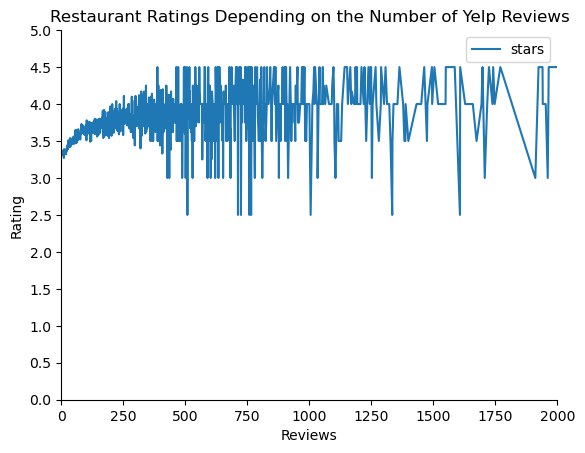

In [21]:
review = []
stars = []
for i in review_summary_statistic.index:
    review.append(review_summary_statistic['review_count'][i])
    stars.append(review_summary_statistic['average_stars'][i])
df = pd.DataFrame({
   'review':review,
   'stars': stars})
lines = df.plot.line(x ='review', y='stars')
lines.set_xlim(0, 2000)
lines.set_ylim(0, 5)
plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
lines.spines['right'].set_visible(False)
lines.spines['top'].set_visible(False)
lines.set_title("Restaurant Ratings Depending on the Number of Yelp Reviews")
lines.set_xlabel('Reviews')
lines.set_ylabel('Rating')

This line graph illustrates the number of reviews restaurants recieve and the average rating that restaurants with the specified reviews recieve. From this graph, it can be observed that when restaurnats have less reviews of around under 250, they tend to recieve ratings of about 3.5 Yelp stars, on average. However, when restaurants have more ratings, the average rating can vary a lot more, and where the range encompasses ratings around 2.5 to 4.5. Observations can be drawn from this data that when more reviews are given, the true quality of the restauarant may be more likely to be reflected. 

### Scatterplot for Number of Reviews and Yelp Rating

Text(0.5, 1.0, 'Restaurant Ratings Depending on the Number of Yelp Reviews')

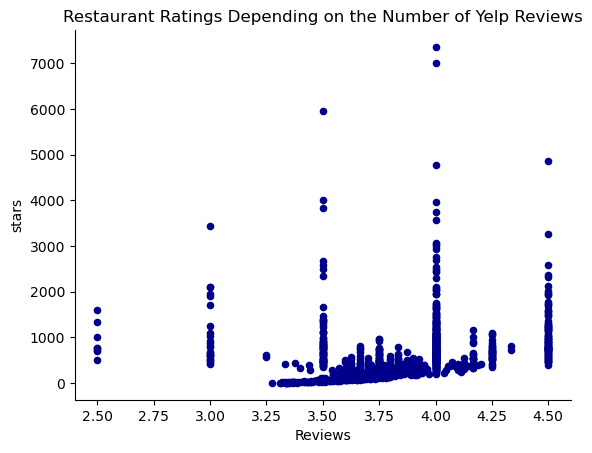

In [271]:
business_groups = df2_business.groupby(['review_count']).mean()
business_groups['reviews'] = business_groups.index
business_groups.head()

ax = business_groups.plot.scatter(x='stars', y='reviews', c='DarkBlue')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Reviews')
ax.set_ylabel('stars')

ax.set_title("Restaurant Ratings Depending on the Number of Yelp Reviews")

This scatterplot continues to investigate the relationship between the number of reviews a restaurant receives on the Yelp rating it receives. The plot appears to be right skewed towards higher ratings which suggest that restaurants with more reviews tend to have higher ratings about 4.0 stars having the most number of reviews. This may be due to the popularity and reputation of an establishment which would succumb users to writing a review.

### Scatterplot for the  Rating Restaurants Recieve Depending on the Number of Checkins

Text(0.5, 1.0, 'Restaurant Ratings Depending on Checkins')

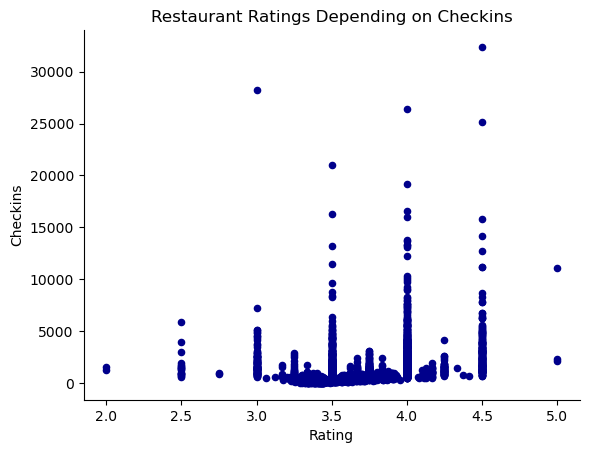

In [318]:
checkin_groups = df2_checkin.groupby(['checkins']).mean()
checkin_groups['checkins'] = checkin_groups.index
checkin_groups.head()

ax = checkin_groups.plot.scatter(x='stars', y='checkins', c='DarkBlue')

ax.set_xlabel('Rating')
ax.set_ylabel('Checkins')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Restaurant Ratings Depending on Checkins")

This scatterplot illustrates the spread of how the number of check-ins restaurants receive correlates with ratings. From this plot, it can be observed that it is more densely packed around a rating of 4 which suggests that people are more likely to check in on Yelp for restaurants when it is considered a 4-star restaurant. These results also reflect how Yelper's may be more likely to interact with a restaurant when they consider it to be around a 4-star rating.

### Bar Chart for Restaurant Categories and the Average Restaurant Rating

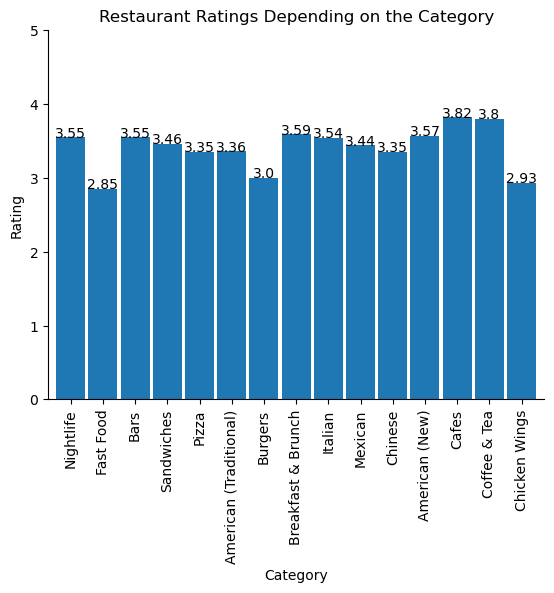

In [24]:
categories = []
stars = []
for i in category_summary_statistic.index:
    categories.append(category_summary_statistic['categories'][i])
    stars.append(category_summary_statistic['average_stars'][i])
df = pd.DataFrame({'category': categories, 'stars': stars})

ax = df.plot.bar(x='category', y='stars', width = 0.9, legend=False)
ax.set_xlabel('Category')
ax.set_ylabel('Rating')
ax.set_title("Restaurant Ratings Depending on the Category")
plt.yticks([0, 1, 2, 3, 4, 5])

for i in range(len(categories)):
        plt.text(i,stars[i],stars[i], ha= 'center')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

This bar chart illustrates the top 15 categories that restaurants are tagged with and the average rating which restaurants in those categories receive. This is an correlation to observe because it can predict the average rating a restaurant may recieve if they fall under this category, or if they add this category to their restaurant description. Additionally, it can reflect the quality of the restaurants under these categories. For example, restaurants that fall under the 'Fast Food' and 'Burger' category on average receive less ratings than the other most common retaurant categories which could lead to a potential analysis of whether fast food restuarant quality is on average worse than restaurants in the other categories. 

### Boxplot for Average Restaurant Rating Based on the City

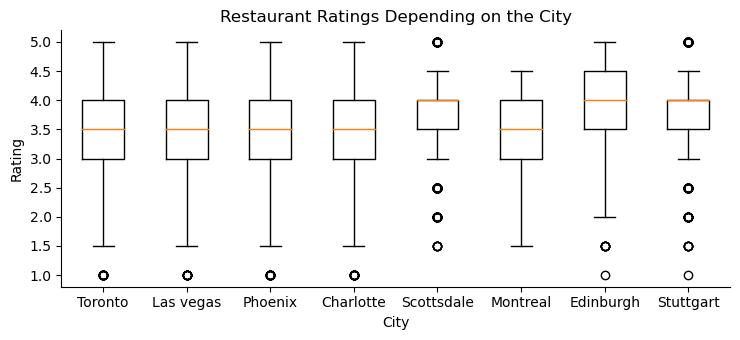

In [25]:
new_frame = {'Toronto':[], 'Las vegas':[], 'Phoenix':[], 'Charlotte':[], 'Scottsdale':[], 'Montreal':[], 'Edinburgh':[], 'Stuttgart':[]}
df2_city = df2_business[['city','stars']]

for i in df2_city.index:
    if df2_city['city'][i] in new_frame:
        new_frame[df2_city['city'][i]].append(df2_city['stars'][i])

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

data = new_frame
fig, ax = plt.subplots()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.boxplot(data.values())
ax.set_xticklabels(data.keys())
ax.set_xlabel('City')
ax.set_ylabel('Rating')
ax.set_title("Restaurant Ratings Depending on the City")
plt.show()

This boxplot represents the average rating of restaurants based on the city they are located in. Results from this plot can lead to further conclusions of restaurant quality depending on the city, or possibly how Yelpers review restaurants in those cities. For restaurants, this data could be important so that they can expect, on average, the kind of review they may receive. For Yelpers, this data could be important for knowing the quality of restaurants they can expect when in a city. The boxplot's findings show how cities in North America tend to receive Yelp ratings of around 3.5 stars, while cities in Europe tend to receive higher Yelp ratings of around 4.0 stars. These results may lead to further elaboration on whether Yelpers in North America and Europe rate restaurants differently, or whether restaurant quality is on average better in Europe. 

### Boxplot for Average Restaurant Rating Based on the State

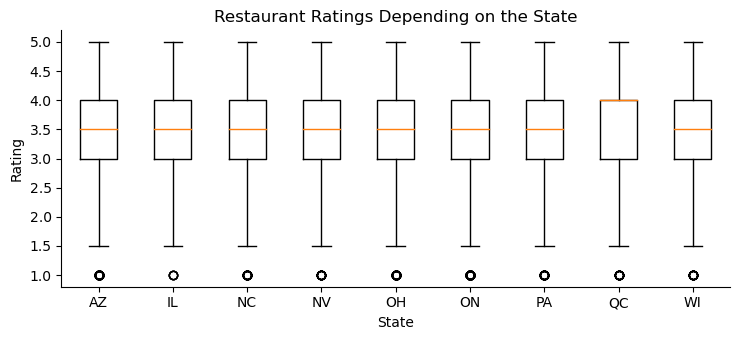

In [26]:
df2_state = df2_business[['state','stars']]

new_frame = {'AZ':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'ON':[], 'PA':[], 'QC':[], 'WI':[]}

for i in df2_state.index:
    if df2_state['state'][i] in new_frame:
        new_frame[df2_state['state'][i]].append(df2_state['stars'][i])

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

data = new_frame
fig, ax = plt.subplots()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.boxplot(data.values())
ax.set_xticklabels(data.keys())
ax.set_xlabel('State')
ax.set_ylabel('Rating')
ax.set_title("Restaurant Ratings Depending on the State")
plt.show()


This boxplot illustrates the average restaurant ratings of restaurants based on the state they are in. This information could be useful for restaurants to see whether the state location of their restaurant is a factor in the type of rating that they would expect to receive. These states are displayed to represent the top 9 states reported with the highest number of restaurants reported. From this graph, it can be observed that QC is reported to have the highest restaurant ratings, on average. The other states all tend to have average restaurant ratings of around 3.5 stars. Interstingly, QC is the only non-American state, and this observation could lead to two possible conclusions. Yelpers in the United States may on average review restaurants lower than Yelpers in Canada, or the quality of restaurants in Canada may on average be better. The circles on the graph represent outlier restaurants in their respective states.

### Boxplot for Average Restaurant Rating Based on the State Located in the United States

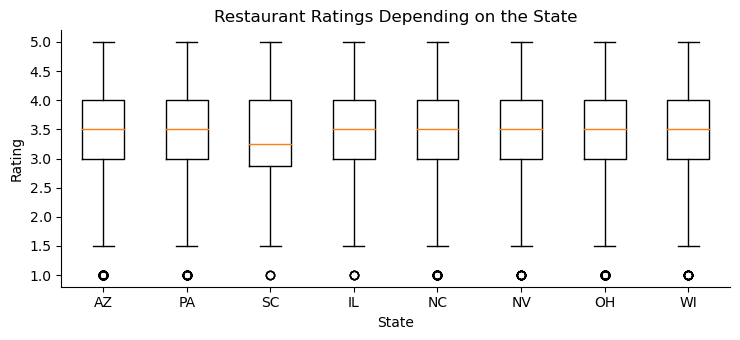

In [27]:
us_df2_state = df2_business[['state','stars']]

new_frame = {'AZ':[], 'PA':[], 'SC':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'WI':[]}
for i in df2_state.index:
    if df2_state['state'][i] in new_frame:
        new_frame[df2_state['state'][i]].append(df2_state['stars'][i])

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

data = new_frame
fig, ax = plt.subplots()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.boxplot(data.values())
ax.set_xticklabels(data.keys())
ax.set_xlabel('State')
ax.set_ylabel('Rating')
ax.set_title("Restaurant Ratings Depending on the State")
plt.show()

This boxplot illustrates the average restaurant ratings of restaurants based on the US state they are in. The states represented are 8 US states reported in the Yelp Dataset From this graph, it is observed that all the restaurants in the states represented except for South Carolina (SC) receive similar Yelp ratings, on average. The range of quartiles of the boxplots are also similar with South Carolina (SC) having a slightly larger range which may suggest that the types of restaurnats in South Carolina may vary in some influencial way in comparison to the other states reported. 

# 2. Project Two

To access images of maps that are unable to produce output in the PDF form, please access this repository under the 'MAPS' folder:
https://github.com/vvickychan/yelp-code.git 


## 2.1 The Message


The main concern of this project is to determine the attributes which determine Yelp review ratings for restuarants located in the United States by analyzing on the state level for the correlation between the number of restaurants on the Yelp rating that restaurants recieve. This question can lead to futher inquires of whether Yelp reviewers in different States rate restaurants on different scales, if restaurants in different states serve at varying quality levels, if there is a strong effect of competition of restaurants on ratings and if there exists socioeconomic differences accross different regions.

A visualization to explore this question involves a heatmap representation of the Yelp data for restaurants in the United States. Every restaurant in the US is represented by a point on the US map where the color of the point is indicative of the rating the restaurant recieves. Through the heatmap, trends regarding restaurant ratings at different geographic levels can be analyzed. On the large scale, restaurant can be observed at the state and city level. On a smaller scale, trends for retaurant ratings around city epicenters can also be observed.

### Heatmap of Restaurants in the US and their Ratings 

In [16]:
# get the state of Arizona
state_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")
county_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_5m.zip")
states = ['AZ', 'IL', 'NC', 'NV', 'OH', 'PA', 'SC', 'WI']

df = df2_business.copy()

# US restaurant coordinates
df["coordinates"] = list(zip(df2_business.longitude, df2_business.latitude))

df["coordinates_point"] = df["coordinates"].apply(Point)
df = df[df.state.isin(states)]

plot = px.density_mapbox(df, lat='latitude', lon='longitude', z='stars', opacity=0.7, radius=5, title="Heatmap of Restaurant Ratings in United States", center=go.layout.mapbox.Center(lat=38, lon=264), zoom=2.7, mapbox_style='stamen-toner')

#'open-street-map'
plot.update_layout(title_text='Heatmap of Restaurants in the US and their Ratings', width=900, height=485)

plot.show()
# pyo.plot(plot)


From the github yelp-code repository, please access yelp-code/MAPS/us_restaurants.pdf to view the map

This heatmap illustrates a density heatmap for the Yelp ratings of restaurants in the United States. Data for only 8 states in the US were included in the Yelp Dataset, but they all similarly reflect the takeaway of higher rated restaurants closer to major cities. On the left, there is a legend indicating the color associated with the restaurant's star rating where yellow is associated with the highest rating of 5 stars and purple is associated with the lowest rating of 0 stars. From the map, it can be observed that higher rated restaurants tend to cluster together, and closer to major cities in their respective states. Using the interactive zoom-in feature of the map, all the states with data reflect this quality. For example, the closer to the major cities of Phoenix Ariozona or Cleaveland Ohio, the more brightly colored yellow points there are. In contrast, it is observed that the further from these major cities, the lower star rating restaurants receive. This heatmap is indicative that there exists factors that result in higher rated restaurants closer to major cities which may be attributed to greater competition and consumer base.

## 2.2 Maps and Interpretations

### Map of Restaurants in the United States

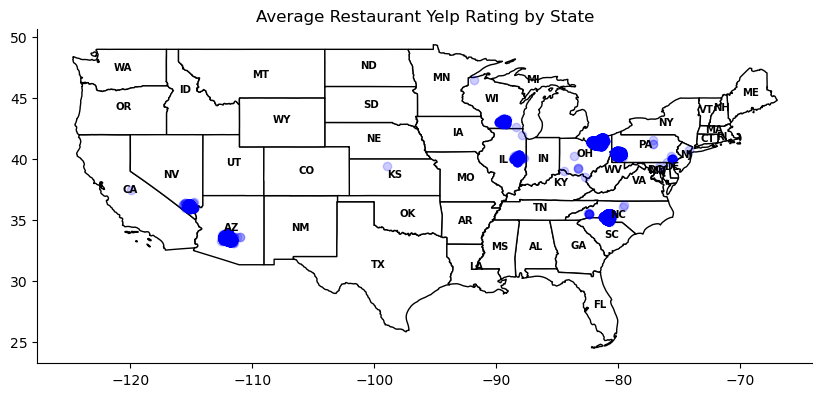

In [19]:
# url of our shape file 
path="/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/cb_2018_us_state_20m"
df_state_data = us_states_1[['state','average_stars']]

# retrieving csv files from paths 
geo_usa = gpd.read_file(path+'/cb_2018_us_state_20m.dbf')
state_data = gpd.read_file('/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/statelatlong.csv')
state_data = state_data.rename(columns={'State': 'STUSPS'})

# merging the data together
geo_merge=geo_usa.merge(df_state_data,how='left', left_on='STUSPS', right_on='state')
geo_merge.fillna('0', inplace=True)

# annotating the graph
geo_merge['coords'] = geo_merge['geometry'].apply(lambda x: x.representative_point().coords[:])
geo_merge['coords'] = [coords[0] for coords in geo_merge['coords']]

remove = ['HI','VI','MP','GU','AK','AS','PR']
main_us = geo_merge
for n in remove:
    main_us = main_us[main_us.STUSPS != n]

fig, gax = plt.subplots(figsize=(10,10))

states_interested = ['AZ', 'IL', 'NC', 'NV', 'OH', 'PA', 'SC', 'WI']

df = df2_business[df2_business.state.isin(states_interested)]
df["coordinates"] = list(zip(df.longitude, df.latitude))
df["coordinates"] = df["coordinates"].apply(Point)
gdf = gpd.GeoDataFrame(df, geometry="coordinates")

main_us.plot(ax = gax, color='white', edgecolor='black')
gdf.plot(ax=gax, color='blue', alpha = 0.2)

for idx, row in geo_merge.iterrows():
    state_text = geo_merge['STUSPS'][idx]
    plt.annotate(text=state_text, xy=row['coords'],
                horizontalalignment='center', fontsize=7.3, weight='bold')

plt.title('Average Restaurant Yelp Rating by State')

gax.spines[['top', 'right']].set_visible(False)


In this map, all the restaurants included in the Yelp Dataset located in the United States are plotted as blue points. The darker blue regions on the map indicate areas where more restaurants are located, and the lighter blue regions on the map indicate areas with less restaurants. From this map it can be observed that there is distinct clustering of restaurants in certain regions which may suggest that restaurants tend to be establish around each other. This phenomena may be due to the business mindset of restaurants for opening in more densly populated city centers.  

### Density Heatmap of Restaurants and their Ratings in Arizona

In [ ]:
# get the state of Arizona
state_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")
county_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_5m.zip")

df = df2_business.copy()
# Arizona restaurant coordinates
df["coordinates"] = list(zip(df2_business.longitude, df2_business.latitude))

df["coordinates_point"] = df["coordinates"].apply(Point)

df_states = df.groupby('state')

# apply the selector to subset

df_arizona = df_states.get_group('AZ')
plot = px.density_mapbox(df_arizona, lat='latitude', lon='longitude', z='stars', opacity=0.5, radius=5, title="Heatmap of Restaurant Ratings in Arizona", mapbox_style="open-street-map")
plot.write_html("myplot.html")
plot.show()

From the github yelp-code repository, please access yelp-code/MAPS/arizona-heatmap.pdf to view the map

This density heatmap of Arizona illustrates the concentration of restaurants in Arizona, against the Yelp star rating that the restaurants receive. From this graph, dense clusters of restaurants are observed around major cities such as Surprise, Glendale, Phoenix, Scottsdale, Chandler and Mecca. Restaurants in those cities tend to receive higher ratings compared to restaurants further from the major cities in Arizona. This data is reflected by the brightly colored yellow center of the map, indicating higher-rated restaurants, and the purple outline indicating lower-rated restaurants. From this map, the conclusion is that areas with a greater density of restaurants tend to have more highly rated restaurants which could be due to the effects of competition, or the types of Yelp reviewers in those areas. 

### Map of the US and average Yelp ratings by state

<AxesSubplot:title={'center':'Average Restaurant Yelp Rating by State'}>

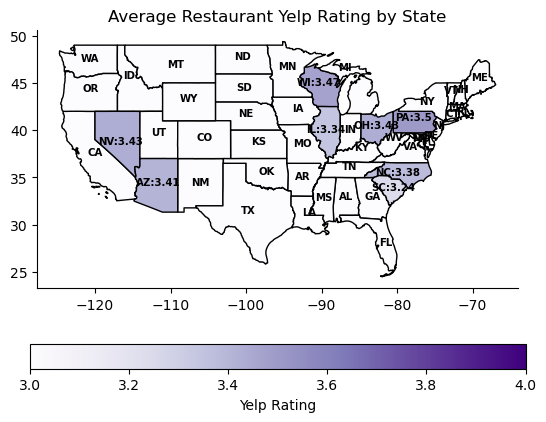

In [20]:
# url of our shape file 
path="/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/cb_2018_us_state_20m"
df_state_data = us_states_1[['state','average_stars']]
# retrieving csv files from paths 
geo_usa = gpd.read_file(path+'/cb_2018_us_state_20m.dbf')
state_data = gpd.read_file('/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/statelatlong.csv')
state_data = state_data.rename(columns={'State': 'STUSPS'})

# merging the data together
geo_merge1=geo_usa.merge(df_state_data,how='left', left_on='STUSPS', right_on='state')
geo_merge1.fillna('0', inplace=True)

remove = ['HI','VI','MP','GU','AK','AS','PR']
main_us = geo_merge1.copy()
for n in remove:
    main_us = main_us[main_us.STUSPS != n]
main_us = main_us.astype({'average_stars': 'float'})

# plotting the map
ax = main_us.plot(column='average_stars', 
                  vmin=3, vmax=4, 
                  cmap='Purples', 
                  edgecolor='black', 
                #   title='Average Restaurant Rating by State',
                  legend=True, 
                  legend_kwds={'label': "Yelp Rating", 'orientation': 'horizontal'})

# annotating the graph
geo_merge1['coords'] = geo_merge1['geometry'].apply(lambda x: x.representative_point().coords[:])
geo_merge1['coords'] = [coords[0] for coords in geo_merge1['coords']]

for idx, row in geo_merge1.iterrows():
    state_text = geo_merge1['STUSPS'][idx]
    if state_text in ['AZ', 'PA', 'SC', 'IL', 'NC', 'NV', 'OH', 'WI']:
        plt.annotate(text=state_text+':'+str(geo_merge1['average_stars'][idx]), xy=row['coords'],
                    horizontalalignment='center', fontsize=7.3, weight='bold')
    else:
        plt.annotate(text=state_text, xy=row['coords'],
                    horizontalalignment='center', fontsize=7.3, weight='bold')
        
# cleaning up the plot's visuals
ax.spines[['top', 'right']].set_visible(False)
plt.title('Average Restaurant Yelp Rating by State')
ax

This map generates a visual for the average Yelp star rating for restaurants in the states with the data provided. The average rating is represented by a purple gradient where states that are white indicate a rating of 0, or the Yelp Dataset did not provide data for that state. The darker the state is shaded purple, the greater the Yelp rating is close to 5. It is apparent that restaurants in the states of Illinois, South Carolina, and North Carolina tend to receive the highest Yelp ratings, on average, while restaurants in Pennsylvania tend to receive the least ratings, on average.

### Map of the US and the Number of restaurants in each State

<AxesSubplot:title={'center':'Average Restaurant Yelp Rating by State'}>

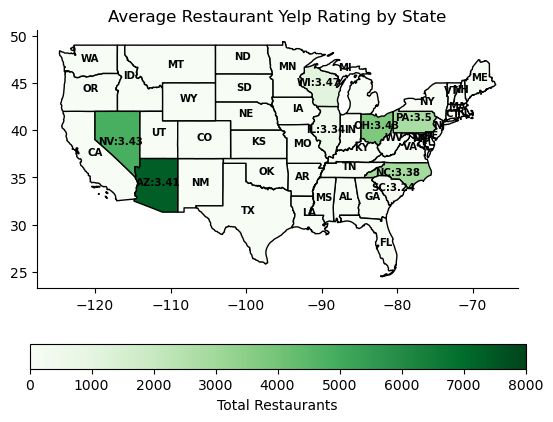

In [21]:
# url of our shape file 
path="/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/cb_2018_us_state_20m"
df_state_data = us_states[['state','total_restaurants', 'average_stars']]
# retrieving csv files from paths 
geo_usa = gpd.read_file(path+'/cb_2018_us_state_20m.dbf')
state_data = gpd.read_file('/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/statelatlong.csv')
state_data = state_data.rename(columns={'State': 'STUSPS'})

# merging the data together
geo_merge2=geo_usa.merge(df_state_data,how='left', left_on='STUSPS', right_on='state')
geo_merge2.fillna('0', inplace=True)

remove = ['HI','VI','MP','GU','AK','AS','PR']
main_us = geo_merge2.copy()
for n in remove:
    main_us = main_us[main_us.STUSPS != n]
main_us = main_us.astype({'total_restaurants': 'float'})

# plotting the map
ax = main_us.plot(column='total_restaurants', 
                  vmin=0, vmax=8000, 
                  cmap='Greens', 
                  edgecolor='black', 
                #   title='Average Restaurant Rating by State',
                  legend=True, 
                  legend_kwds={'label': "Total Restaurants", 'orientation': 'horizontal'})

# annotating the graph
geo_merge2['coords'] = geo_merge2['geometry'].apply(lambda x: x.representative_point().coords[:])
geo_merge2['coords'] = [coords[0] for coords in geo_merge2['coords']]

for idx, row in geo_merge2.iterrows():
    state_text = geo_merge2['STUSPS'][idx]
    if state_text in ['AZ', 'PA', 'SC', 'IL', 'NC', 'NV', 'OH', 'WI']:
        plt.annotate(text=state_text+':'+str(geo_merge2['average_stars'][idx]), xy=row['coords'],
                    horizontalalignment='center', fontsize=7.3, weight='bold')
    else:
        plt.annotate(text=state_text, xy=row['coords'],
                    horizontalalignment='center', fontsize=7.3, weight='bold')
        
# cleaning up the plot's visuals
ax.spines[['top', 'right']].set_visible(False)
plt.title('Average Restaurant Yelp Rating by State')
ax

This map illustrates the number of restaurants included in the Yelp Dataset by the US state. The map records this analysis with a green gradient where the white-colored states indicate that there was no data recorded for a particular state, and the darker green states indicate higher Yelp ratings with a maximum of stars. Observing this map with the map above of the 'Average Yelp Rating by State', there are certain states that show higher ratings for states with more restaurants such as South Carolina (SC) and Illinois (IL) and lower ratings for states with fewer restaurants such as Ohio (OH), but there does not seem to be a consistent correlation. This suggests somewhat of a positive correlation between the number of restaurants in a state and the average rating of restaurants in that state for the effect of competition between businesses. 

## Merging With a New Data Set

### Map of US Personal Income and Average Restaurant Ratings in the US

In [22]:
# merging the restaurant data with the personal income data
income_data_copy = income_data.copy()
income_merge = geo_merge2.merge(income_data_copy,how='left', left_on='NAME', right_on='Name').drop(columns = ['Name'], axis=1)
income_merge.fillna('0', inplace=True)
income_merge['Personal Income'] = income_merge['Personal Income'].astype(float)
fig = go.Figure(data=go.Choropleth(
    locations=income_merge['STUSPS'], # States 
    z = income_merge['Personal Income'], # Color code the personal income
    locationmode = 'USA-states', # Map the US
    colorscale = 'oranges',
    colorbar_title = "Millions USD",
))

fig.add_scattergeo(
    locations=income_merge['STUSPS'],
    locationmode="USA-states", 
    text=income_merge['average_stars'],
    mode='text',
)

fig.update_layout(
    title_text = 'US Personal Income and Restaurant Ratings',
    geo_scope='usa', # limit map scope to USA
)

fig.show()
# pyo.plot(fig)

From the github yelp-code repository, please access yelp-code/MAPS/income_map.pdf to view the map

In this map, the US Personal Income Data is merged with the average restaurant ratings in the respective US states. Previously, the categories of restaurants and their average ratings were compared and the data reflected how fast-food-related restaurants tended to receive lower ratings, on average, in comparison to more sit-down restaurants. This leads to the question of whether the quality of restaurants in an area depends on the income of people living there and the target consumer these restaurants are catering to. By merging the US Personal Income data at a state level, a correlation would reflect that states with higher overall personal income should lead to higher restaurant ratings in those states. In this map, the color bar legend indicates the Personal Income of citizens in the states included in the Yelp Dataset from dark to light, or least to greatest respectively. This is an interactive graph where hovering over the map will show the state being analyzed as well as the average restaurant rating in that state, however, the averages are also printed on the map. Since there were US states not included in the dataset, they are the darkest brown shade with an average rating of 0. 

From this map, some correlation can be observed where for example, Pennsylvania has one of the highest personal incomes and has the highest average Yelp rating and South Carolina has one of the lowest personal incomes and has the Yelp rating, but this finding is not very consistent. This suggests that personal income may have some effect on the quality of restaurants and the Yelp rating they receive, but there may be other factors. For example, because there is a strong correlation between category and Yelp rating, the ratio of fast-food to sit-down restaurants in each state may also have an impact on the average rating of restaurants in each state. 

# 3. Project Three

## 3.1 Potential Data to Scrape

Data that can be scraped to enhance the analysis of factors which result in high quality restuarants in a region would be observing the median age of first marriage across the US states. By observing whether a correlation lies between marraige age and Yelp ratings of restaurants, the theory of whether the socioeconomic characteristics attached to age of marriage has an effect on the quality of restaurants in a region. A proposed theory to test would be investigating whether regions with older median marriage ages would result in higher quality restaurants which would be reflective in higher Yelp ratings, on average. This phenomenon is proposed to occur becuase people who choose to become married later in age may eat out more due to more dispensible income due to the smaller likelihood that they have people to provide for as well as more time to explore and demand quality restaurants. 

This data can be collected from the United States Census Bureau's API under the American Community Survey for Median Age At First Marriage at the state level which can be found at https://data.census.gov/table?t=Marital+Status+and+Marital+History&g=040XX00US04. Through the US Census Bureau's API, the data for the median marriage age for men and women can be collected and exported as a CSV file, which can be merged based on the US state that restaurants are located in to create visualizations and determine whether a correlation lies between the median age at first marriage and the average Yelp ratings of restaurants in the US from the Yelp Dataset.  

The scraped data from the US Census Bureau can be merged with the current Yelp data based on the states to represent the median age of marraige between men and women. Both genders will be visualized seperately due to the 

## 3.2 Potential Challenge

Potential challenges and considerations regarding scraping this data are that it has been observed that the average age at which individuals choose to become married has been on the rise, especially due to factors such as cultural shifts regarding the construct of marriage and an uptick of women in the workforce. Therefore, it may be even more beneficial to observe the change in the age of first marriage over the years against the average Yelp rating of restaurants during those years for each US state. To navigate this potential effect, only the results from the Census during the year the dataset was published, 2021, can be analyzed. The dataset provides the average age of first marriage for males and females, individually. Upon observation, males tend to enter their first marriage later in life in comparison to females so this discrepancy may be significant. To further analyze this when creating visualizations and modelling the data, the relationship between the median age of marriage for males and females individually against average Yelp ratings for restaurants in US states can be created. Additionally, a new column to determine the average median age of marriage for men and women, collectively, can also be visualized and modelled. Through this method, the question of whether the median age of a specific gender and marriage or the entire population as a whole depicts a stronger correlation can be determined.

## 3.3 Scraping Data from a Website

In order to obtain the URL for web scraping, the "American Community Survey Data" via API was accessed through the United States Census Bureau website. Specifically, group number B12007 was analyzed in order to retrieve the data for "Median Age at First Marriage". The data table represented was under "Detailed Tables", and specifically the "ACS 1-Year Estimates Detailed Tables" for 2021 were analyzed. The call URL for detailed tables was used where the geography level and group number were adjusted to be at the state level for group B12007.

In [23]:
# URL from US Census Bureau API
url = 'https://api.census.gov/data/2021/acs/acs1?get=NAME,group(B12007)&for=state'

r=requests.get(url)
open('state_median_marriage_2021.csv', 'wb').write(r.content)

4904

In [24]:
fname = 'state_median_marriage_2021.csv' # the data in the cv file
df = pd.read_csv(fname)                  # reading the csv file as a pandas df

Now that the data has been scraped using the US Census Bureau's API, the data is cleaned to remove unnecessary factors and set up to be merged with the previously cleaned Yelp data. Additionally, the average age of first marriage for both genders in their respective states is calculated.

In [25]:
marriage_df = df.copy()

# cleaning the data from API
# keep B12007_001E for median age of men and B12007_002E for median age of women
first = marriage_df.pop('NAME') 
marriage_df.insert(0, 'NAME', first) 

marriage_df = marriage_df.rename(columns={'state]': 'state', 'B12007_001E': 'Men', 'B12007_002E': 'Women', 'NAME': 'State'}).drop(['[["NAME"', 'state', 'B12007_001M', 'B12007_002M'], axis=1).dropna(axis=1)

# add the STUSPS which will be used to merge with the dataframes created earlier
state_data = gpd.read_file('/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/statelatlong.csv')
state_data = state_data.rename(columns={'State': 'STUSPS', 'City': 'State'})
marriage_df = marriage_df.merge(state_data,how='left', on='State').drop(['Latitude', 'Longitude', 'geometry'], axis=1).dropna()

second = marriage_df.pop('STUSPS') 
marriage_df.insert(0, 'STUSPS', second) 

marriage_df['Average'] = marriage_df[['Men', 'Women']].mean(axis=1)

fourth = marriage_df.pop('Average') 
marriage_df.insert(4, 'Average', fourth) 

marriage_df.head(10)

,STUSPS,State,Men,Women,Average,GEO_ID
0,AL,Alabama,29.6,27.2,28.40,0400000US01
2,AZ,Arizona,30.5,27.6,29.05,0400000US04
3,AR,Arkansas,27.5,25.9,26.70,0400000US05
4,CA,California,31.8,30.0,30.90,0400000US06
5,CO,Colorado,30.7,28.4,29.55,0400000US08
6,CT,Connecticut,31.0,30.1,30.55,0400000US09
7,DE,Delaware,30.8,29.4,30.10,0400000US10
8,DC,District of Columbia,33.1,30.8,31.95,0400000US11
9,FL,Florida,31.7,29.3,30.50,0400000US12
10,GA,Georgia,30.4,28.0,29.20,0400000US13


From this dataframe, the Median Age of First Marriage for men, women, and the average of men and women is shown for the states included in the Yelp Dataset. The "STUSPS", "state" and "GEO_ID" columns indicate the state and location being described. The "Men", "Women", and "Average" columns reflect the average age of first marriage for these gender demographics and for the population overall. From this data, it is apparent that women consistently enter marriage earlier than men. Additionally, people on the east coast in states such as Connecticut and Delaware tend to become married later in age in comparison to the rest of America.

## 3.4 Merging the Scraped Dataset

Now, the scraped data from the US Census Bureau can be merged with the existing Yelp dataset in this paper.

In [26]:
# contains the scraped data for age of first marraige for men and women in all US states 
us_states_copy = us_states.copy()
us_states_copy = us_states_copy.rename(columns={'state': 'STUSPS'})

# merge with the cleaned Yelp data
merged_marriage = marriage_df.merge(us_states_copy, on='STUSPS', how='outer').drop(columns=['GEO_ID'], axis=1)
merged_marriage.fillna('0', inplace=True)

merged_marriage.head(15)

,STUSPS,State,Men,Women,Average,average_stars,total_restaurants,review_total
0,AL,Alabama,29.6,27.2,28.40,0,0,0
1,AZ,Arizona,30.5,27.6,29.05,3.41,7367.0,788960
2,AR,Arkansas,27.5,25.9,26.70,0,0,0
3,CA,California,31.8,30.0,30.90,0,0,0
4,CO,Colorado,30.7,28.4,29.55,0,0,0
5,CT,Connecticut,31.0,30.1,30.55,0,0,0
6,DE,Delaware,30.8,29.4,30.10,0,0,0
7,DC,District of Columbia,33.1,30.8,31.95,0,0,0
8,FL,Florida,31.7,29.3,30.50,0,0,0
9,GA,Georgia,30.4,28.0,29.20,0,0,0


In this dataframe, the clean scraped data for the median age of first marriage and the Yelp dataframe from the previous project are merged. Since the Yelp dataframe does not provide data for all US states only the ones included in the dataset have values for the columns "total_restaurants", "average_stars" and "review_total". From the Yelp Dataset, there are a total of 2,236,930 recorded observations for the reviews in the US states provided for open restaurants. According to the US Census Bureau on the American Community Survey for annual samples, the scraped data consists of about 3.5 million observations (Understanding and Using American Community Survey Data, n.d.). 

## 3.5 Visualizing the Scraped Dataset

### Thematic Map for Median Age of First Marriage for Men and Average Restaurant Ratings by State

In [27]:
path="/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/cb_2018_us_state_20m"
state_data = gpd.read_file('/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/statelatlong.csv')
# retrieving csv files from paths 
geo_usa = gpd.read_file(path+'/cb_2018_us_state_20m.dbf')

geo_merge = geo_usa.merge(merged_marriage, on='STUSPS')

geo_merge_states = geo_merge.copy()
for idx, row in geo_merge_states.iterrows():
    state_text = geo_merge_states['STUSPS'][idx]
    if state_text not in ['AZ', 'PA', 'SC', 'IL', 'NC', 'NV', 'OH', 'WI']:
                geo_merge_states.drop([idx], axis=0, inplace=True)
                
fig = px.choropleth(geo_merge,
              locations=geo_merge['STUSPS'],
              locationmode = 'USA-states',
              scope = 'usa',
              color = geo_merge['Men'],
              color_continuous_scale='Reds',
              range_color = [24,32],
              hover_data = [geo_merge['Men']],
              title = 'Median Marriage Age of First Marriage for Men and Average Yelp Rating for US States')

fig.add_scattergeo(
        locations=geo_merge_states['STUSPS'],
         locationmode="USA-states",
         text=geo_merge_states['average_stars'], 
         mode='text',
         textfont_size=12
)

fig.show()
# pyo.plot(fig)

From the github yelp-code repository, please access yelp-code/MAPS/marriage_men.pdf to view the map

In this map, the median marriage age of men determines the color of the state, and the average ratings of restaurants in the respective state are printed on the map as well as through the hover function. The darker shade of red the state is, the greater the median age of marriage in that state. There does seem to be some correlation between later marriage and quality of restaurants as seen in  darker shaded states such as Nevada and Pennslyvania with two of the higher average restaurant ratings. States such as South Carolina with an earlier median marriage age exhibit restaurants with lower rated restaurants, on average. These results are somewhat conclusive of there being a correlation between marriage age and quality of restaurants. 

### Thematic Map for Median Age of First Marriage for Women and Average Restaurant Ratings by State

In [28]:
path="/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/cb_2018_us_state_20m"
state_data = gpd.read_file('/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/statelatlong.csv')
# retrieving csv files from paths 
geo_usa = gpd.read_file(path+'/cb_2018_us_state_20m.dbf')

geo_merge = geo_usa.merge(merged_marriage, on='STUSPS')
geo_merge.fillna('0', inplace=True)

fig = px.choropleth(geo_merge, 
              locations = geo_merge['STUSPS'],
              locationmode = 'USA-states',
              scope ='usa',
              color = geo_merge['Women'],
              color_continuous_scale='Reds',
              range_color = [24,32],
              hover_data = [geo_merge['Women'], geo_merge['average_stars']],
              title = 'Median Marriage Age of First Marriage for Women and Average Yelp Rating for US States')
fig.add_scattergeo(
        locations=geo_merge_states['STUSPS'],
         locationmode="USA-states",
         text=geo_merge_states['average_stars'],
         mode='text',
         textfont_size=12
)
fig.show()
# pyo.plot(fig)

From the github yelp-code repository, please access yelp-code/MAPS/marriage_women.pdf to view the interactive map

In this map, the median marriage age of women determines the color of the state, and the average ratings of restaurants in the respective state are printed on the map as well as through the hover function. Like the previous map, the darker shade of red the state is, the greater the median age of marriage in that state. There does seem to be some correlation between later marriage and quality of restaurants as seen in darker shaded states such as Nevada and Pennsylvania with two of the higher average restaurant ratings, however, it does not appear as strong when compared to the thematic map with median marriage age of men and average restaurant ratings. 


The split analysis of genders was decided due to the notable difference in marriage age of women in comparison to men where men tend to become married later in life. This allows for deeper insight as to whether there is a difference in the correlation between median marriage age and quality of restaurants. Based on the two maps, there does seem to be somewhat of a difference between men and women where average restaurant ratings in a state tend to correlate more to the age of first marriage for men.

## 3.4 Adding a New Dataset

### Scatterplot for Average Family Size and Restuarants with Above Average Ratings in the US

From the American Community Survey by the United States Census Bureau, the ACS 1-Year Estimates Data Profiles dataset for Selected Social Characteristics in the United States during 2021 was merged with the current data from the Kaggle Yelp Dataset in this paper. The attribute for average family size in states was specificed to analyze whether there exists a correlation between family sizes and the quality of restaurants in a particular region. There are many underlying socioeconomic factors which may contribute to varying family size across the US states. Individuals decide on family size based on a variety of factors from cultural norms, to the expenses of raising children in some regions versus others. These underlying factors may also contribute to the makeup of restaurants in certain regions and result in varying quality levels of these establishments. 

In [29]:
# retrieving the dataset
household_size = pd.DataFrame(pd.read_csv('/Users/vickychan/Dropbox/Mac/Desktop/yelp-code/us_household_size.csv'))
household_size_copy = household_size.copy()

# creating a new dataset that extracts the data for family size in each state
cols = household_size_copy.columns.values.tolist()

new_household = household_size_copy[['Label (Grouping)']].copy()

for i in cols:
    if 'Estimate' in i:
        new_household[i] = household_size_copy[i].copy()
        new_household.columns = new_household.columns.str.replace('!!Estimate', '')

new_household = new_household.loc[[17]].T
new_household.reset_index(inplace=True)

new_household.rename({'index': 'NAME', 17: 'avg_family_size'}, axis=1, inplace=True)
new_household.drop([0,1], axis=0)

# merging with previous data
merged_household = geo_merge.merge(new_household,how='left', on='NAME')
merged_household.fillna('0', inplace=True)

for idx, row in merged_household.iterrows():
    state_text = merged_household['STUSPS'][idx]
    if state_text not in ['AZ', 'PA', 'SC', 'IL', 'NC', 'NV', 'OH', 'WI']:
        merged_household.drop([idx], axis=0, inplace=True)
merged_household = ratio_df.merge(merged_household, how='left', on='STUSPS').sort_values('avg_family_size')

<Figure size 2000x2000 with 0 Axes>

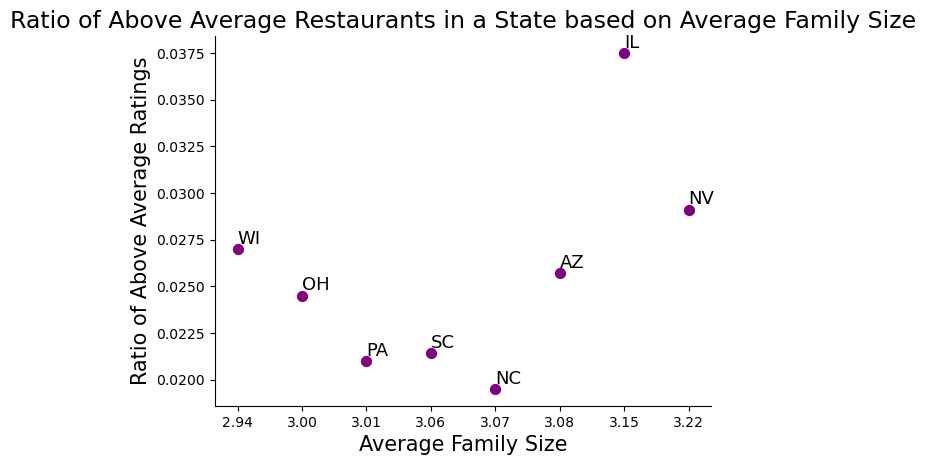

<Figure size 2000x2000 with 0 Axes>

In [32]:
ax = merged_household.plot.scatter(x='avg_family_size', y='ratio', s=50, c='purple')
for idx, row in merged_household.iterrows():
    ax.annotate(row['STUSPS'], (row['avg_family_size'], row['ratio']+.0003), fontsize=13)
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlabel('Average Family Size', fontsize=15)
ax.set_ylabel('Ratio of Ratings above 4', fontsize=15)
ax.set_title('Ratio of Restaurants with Ratings Above 4 in a State based on Average Family Size', fontsize=17)

plt.figure(figsize=(20,20))


This scatterplot reflects the relationship between the average family size in US states for those included in the Yelp Dataset against the ratio of restaurants with ratings above in those states. A restaurant is considered to be above average if it has greater than 4 stars. Based on the scatterplot there seems to be a curvilinear relationship between the two variables. States that on average have smaller family sizes with less than 3 people such as Wisconsin and Ohio tend to have a higher ratio of restaurants with ratings above 4. On the other end of the spectrum, states with the largest family sizes included in the US dataset such as Illinois and Nevada also have a higher ratio of restaurants with ratings above 4. States with family sizes between these extremes exhibit a lower ratio of above-average restaurants. 

These findings suggest an interesting correlation between household demographics, their underlying economic status, and the quality of restaurants in states. A plausible inference that can be made is that smaller families tend to have more disposable income and time to explore restaurants. This would result in a greater ratio of high-quality restaurants. Additionally, it may be plausible that individuals with greater wealth will choose to have larger families and this may result in a greater ratio of high-quality restaurants in those regions.

# Final Project 

In [370]:
# Merging all analysis into the a dataframe of restaurants in the USA 
states = ['AZ', 'PA', 'SC', 'IL', 'NC', 'NV', 'OH', 'WI']
ind = []
df_us_restaurants = df2_business.copy()
for i in df_us_restaurants.index:
    if df_us_restaurants['state'][i] not in states:
        ind.append(i)
df_us_restaurants = df_us_restaurants.drop(ind, axis=0)

# merge with personal income data for each state
df_us_restaurants = pd.merge(df_us_restaurants, income_merge[['STUSPS', 'Personal Income']], how='left', left_on='state', right_on='STUSPS')

# merge with marriage data and general restaurant statistics 
df_us_restaurants = pd.merge(df_us_restaurants, merged_marriage[['STUSPS', 'Men', 'Women', 'Average', 'total_restaurants', 'average_stars']], how='left', left_on='state', right_on='STUSPS')

# merge with ratio of restaurants with ratings above 4.5 in each state
df_us_restaurants = pd.merge(df_us_restaurants, ratio_df[['STUSPS', 'percentage']], how='left', left_on='state', right_on='STUSPS')


df_us_restaurants =  df_us_restaurants.rename(columns={'Men': 'firstmarrmen', 'Women': 'firstmarrwomen', 'Average': 'firstmarravg', 'average_stars': 'stateavgstrs', 'Personal Income': 'personalinc', 'review_count': 'num_reviews'})

# converting some values into representable quantities for regressions

# personal income in each state in billlions 
df_us_restaurants['incomebill'] = df_us_restaurants['personalinc']/100000
# num of restaurants in thousands
df_us_restaurants['totalrstrns'] = df_us_restaurants['total_restaurants']/1000
# number of reviews in hundreds
df_us_restaurants['totalreviews'] = df_us_restaurants['num_reviews']/100

# clean columns
df_us_restaurants = df_us_restaurants.drop(columns = ['STUSPS_x', 'STUSPS_y', 'STUSPS', 'total_restaurants'], axis=1)

# 4.1 OLS Regression

In [371]:
X = df_us_restaurants.drop(["business_id", "name", "neighborhood", "address","city", "state", "postal_code", "latitude", "longitude", "categories", "is_open"], axis=1).copy()
# convert everything to be a float for later on

for col in list(X):
    X[col] = X[col].astype(float)

In [372]:

# taking the log of x's to create a level-log regression
df = df_us_restaurants.drop(["business_id", "name", "neighborhood", "address","city", "state", "postal_code", "latitude", "longitude", "categories", "is_open"], axis=1).copy()
# df["totalrstrns"] = np.log(df["totalrstrns"].astype('float64'))
df["logtotalreviews"] = np.log(df["totalreviews"])
df["logpercentage"] = np.log(df["percentage"])

for col in list(df):
    df[col] = df[col].astype(float)

From project 1, the variables for total restaurants in the state a restuarant is located, the number of reviews, the percentage of restaurants with ratings above 4.5 stars, the personal income in the state, and the median age of first marraige are considered significant in determining the rating of a restaurant.

In [373]:
df['const'] = 1

# Create lists of variables to be used in each regression
X1 = ['const', 'totalrstrns', 'logtotalreviews']
X2 = ['const', 'totalrstrns', 'logtotalreviews', 'logpercentage']
X3 = ['const', 'totalrstrns', 'logtotalreviews', 'logpercentage', 'incomebill']
X4 = ['const', 'totalrstrns', 'logtotalreviews','logpercentage', 'incomebill', 'firstmarravg']


# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df['stars'], df[X1].astype(int), missing='drop').fit()
reg2 = sm.OLS(df['stars'], df[X2].astype(int), missing='drop').fit()
reg3 = sm.OLS(df['stars'], df[X3].astype(int), missing='drop').fit()
reg4 = sm.OLS(df['stars'], df[X4].astype(int), missing='drop').fit()

In [374]:
from statsmodels.iolib.summary2 import summary_col
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}", 
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

In [375]:
results_table = summary_col(results=[reg1,reg2,reg3, reg4],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 2',
                                         'Model 3',
                                         'Model 4'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'totalrstrns',
                                             'logtotalreviews',
                                             'logpercentage',
                                             'firstmarravg',
                                             'incomebill'
                                             ])
stargazer = Stargazer([reg1, reg2, reg3, reg4])
# print(results_table)

HTML(stargazer.render_html())

These regressions were chosen based on the related socioeconomic factors regarding the populations characteristics for restaurants located in the US from the Yelp Dataset. Additionally, they consider a restaurant's Yelp rating in relation to the performance and statistics of other restaurants for the state the restaurant is located in. 

The first regression considers the total number of restaurants in the state as a measure of the competition a restaurant faces, and the total number of reviews a restaurant receives. The second regression builds on the first and continues refining the characteristics of how restaurants in a particular state perform with the consideration of the percentage of restaurants with ratings above 4.5 stars, which is considered an exceptional rating on Yelp. The third regression considers the personal income of individuals in the state a restaurant is located. The fourth and final regression adds the variable for median marriage age in the state a restaurant is located in to study whether there is a correlation between marriage age on the rating of a restaurant.

To determine the preferred model, the "F statistic" row is consulted. Since all F statistics are greater than 0.05, the p-value, all of the models are significant indicating that there exists a relationship between the predicted results and the actual results. Next, the "Adjusted $R^2$" values are analyzed to determine the degree of how variance in the data can be explained by the model and accounting for the predictors. An adjusted $R^2$ closer to 1 is preferred since it indicates a greater proportion of the data variance being explained by the model. Since model 3 and 4 have the greatest adjusted $R^2$ value of 0.078, the "Residual Std. Error" row is compared where a lower error is preferred. Since Modek 4 has the lower Residual standard error of 0.794, it is the preferred model. 

From our results, for model 4 we see that

- The intercept $ \hat{\beta}_0 = 1.824.$.  
- The slope $ \hat{\beta}_1 = -0.017$.  
- The negative $ \hat{\beta}_1 $ parameter estimate implies that the number of restuarants in a state is negatively correlated with the rating of restaurants.
- The slope $ \hat{\beta}_2 = 0.209 $.  
- The positive $ \hat{\beta}_2 $ parameter estimate implies that.
  the number of reviews is positively correlated with the rating of restaurants
  - The slope $ \hat{\beta}_3 = -0.136 $.  
- The negative $ \hat{\beta}_3 $ parameter estimate implies that the percentage of restuarants above 4.5 stars is negatively correlated with the rating of restaurants.
- The slope $ \hat{\beta}_4 = 0.014 $.  
- The positive $ \hat{\beta}_4 $ parameter estimate implies that the personal income of individuals in positively correlated with the rating of restaurants.
- The slope $ \hat{\beta}_5 = 0.062 $.  
- The positive $ \hat{\beta}_1 $ parameter estimate implies that the median marriage age of individuals in positively correlated with the rating of restaurants.

- The p-value of 0.004 for $ \hat{\beta}_1 $ implies that the
  effect of total restaurants on ratings is statistically significant (using p < 0.05 as a rejection rule).  
- The p-value of 0.005 for $ \hat{\beta}_2 $ implies that the
  effect of restaurant reviews is statistically significant (using p < 0.05 as a rejection rule).  
- The p-value of 0.028 for $ \hat{\beta}_3 $ implies that the
  percentage of restaurants with ratings above 4.5 is statistically significant (using p < 0.05 as a rejection rule).  
- The p-value of 0.005 for $ \hat{\beta}_4 $ implies that the
  effect of personal income in US states is statistically significant (using p < 0.05 as a rejection rule).
- The p-value of 0.062 for $ \hat{\beta}_5 $ implies that the
  effect of restaurant reviews is not statistically significant (using p < 0.05 as a rejection rule) however the variable will be retained in the model
- The R-squared value of 0.070 indicates that around 7.9% of variation
  in ratings is explained by the socioeconomic and restaurnats specific variables in Model 4


Using our parameter estimates, we can now write our estimated
relationship as:


$$
\widehat{stars} = 1.824 - 0.017 \ \widehat{totalrstrns}_i - 0.209 \ \widehat{logtotalreviews}_i - 0.136 \ \widehat{logpercentage}_i + 0.014 \ \widehat{incomebill}_i + 0.062 \ \widehat{firstmarravg}_i 
$$

The equation above describes the line of best fit from Model 4 to predict the log level of restaurant ratings for the values of total restaurants in a state, total reviews, the percentage of restaurants with ratings above 4.5 in the proximity, the personal income in a state and the median age of first marriage in a state. The equation produces a straight line that passes through the datapoints associated with the variables in Model 4 and restaurant ratings as close as possible. 


Based on the overall statistical results, the adjusted $R^2$ values indicate that a linear regression is not a strong fit to determine correlation between the variables and restaurant ratings. 

Below is a regression between number of restaurant reviews and the rating of restaurants, which is a variable in Model 4, and visualizes what most of the individual regressions of the variables produce.  

### Non-Regression for Restaurant Reviews and their Rating

In [383]:
business_groups = business_groups[business_groups.stars != 1]
business_groups = business_groups[business_groups.stars != 2]
business_groups = business_groups[business_groups.stars != 2.5]
business_groups = business_groups[business_groups.stars != 3]
business_groups = business_groups[business_groups.stars != 3.5]
business_groups = business_groups[business_groups.stars != 4]
business_groups = business_groups[business_groups.stars != 4.5]
business_groups = business_groups[business_groups.stars != 5]

In [384]:
poly = PolynomialFeatures(degree=2, include_bias=False)
x = np.log(business_groups['reviews'].astype('float64'))
y = business_groups['stars']


poly_features = poly.fit_transform(x.values.reshape(-1, 1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)
y_predicted = poly_reg_model.predict(poly_features)

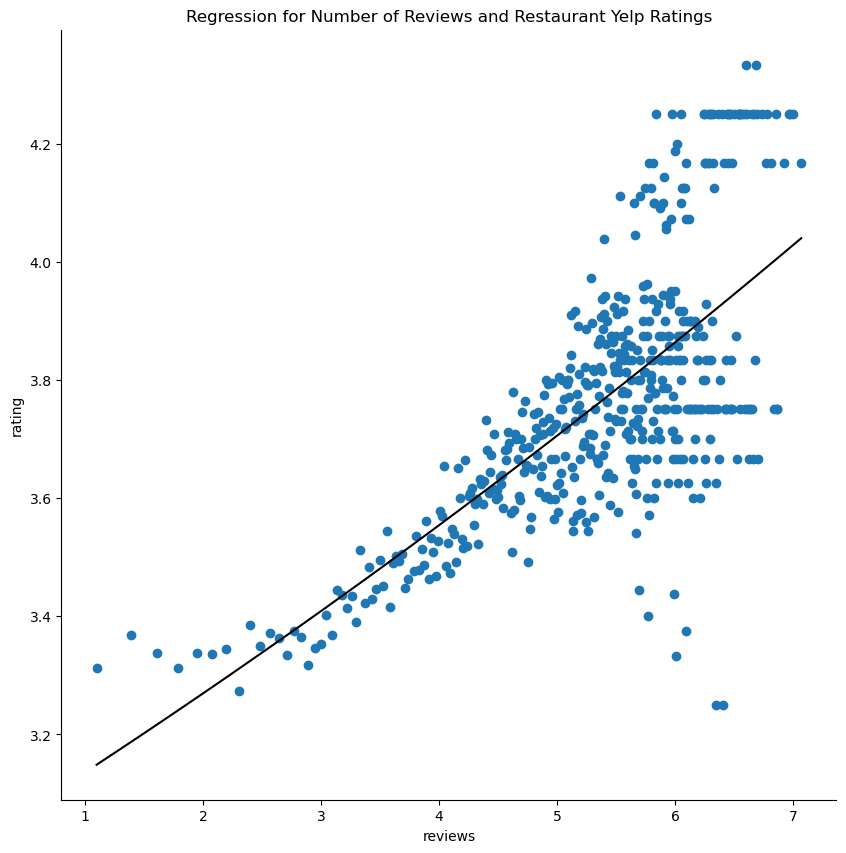

In [385]:
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.scatter(x, y)
ax.set_title("Regression for Number of Reviews and Restaurant Yelp Ratings")

p = np.polyfit(x, np.log(y), 1)
a = np.exp(p[1])
b = p[0]
x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = a * np.exp(b * x_fitted)

ax.plot(x_fitted, y_fitted, 'k', label='Fitted curve')
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.xlabel('reviews')
plt.ylabel('rating')
plt.show()

In this plot, the regression for the natural logarithm of reviews a restaurant recieves and the rating they recieved is plotted as a bins scatterplot with an exponential regression curve since the data points do not appear to increase at a constant rate. Therefore, this relationship is not linear. The natural logarithm is taken since there is a percent change that can be associated with a unit change in the number of reviews a restaurant recieves. The exponential regression seems to be a better predictor compared to a linear regression since it is able to capture more of the data points for reviews after 5.5 that continue in the incrasing faashion that the datapoints trend in. Horizontal clusters of datapoints in the graph indicate numbers of reviews that many restaurants do not share, and therefore produce rating averages that only contain data from a small number of restaurants resulting in whole or rounded values such as ratings of 2 or 3.5. The dataset plotted was cleaned of datapoints that had these "whole" or "rounded" values to create a better visualization of the general trend of the data. 

## 4.2 Machine Learning

In [396]:
X = df
# convert everything to be a float for later on

for col in list(X):
    X[col] = X[col].astype(float)

y = df["stars"]

In [403]:
# creating the linear model
lr_model = linear_model.LinearRegression()
lr_model.fit(X, y)

LinearRegression()

In [421]:
y_pred_linear = lr_model.predict(X)
full_mse = metrics.mean_squared_error(y, y_pred_linear)
print('Linear Model Mean Squared Error:', full_mse)

Linear Model Mean Squared Error: 1.3232883560685551e-27


In [407]:
star_tree = tree.DecisionTreeRegressor(max_depth=3).fit(X,y)

In [422]:
# use the fitted tree to predict the error 
y_pred_tree = star_tree.predict(X)

print('Fitted Tree Mean Squared Error:', metrics.mean_squared_error(y, y_pred_tree))

Fitted Tree Mean Squared Error: 0.21445117218032972


From the regression tree with depth 3, a mean squared error of 0.00154 results which is worse than the mean squared error from the linear regression of 1.3233e-27. More depth could be added, however, the regression would risk overfitting the data being a poor predictor for the dataset at large.

### Regression Tree for US Restaurant Ratings 

In [427]:
# fitted_tree = tree.DecisionTreeRegressor(max_depth=3).fit(X,y)
# fig = plt.figure(figsize=(25,20))
# fig = tree.plot_tree(fitted_tree, feature_names=['totalrstrns', 'logtotalreviews','logpercentage', 'incomebill', 'firstmarravg'], filled=True)

In [425]:
star_tree = tree.DecisionTreeRegressor(max_depth=3, ccp_alpha = 0.1).fit(X,y)

y_pred_tree = star_tree.predict(X)

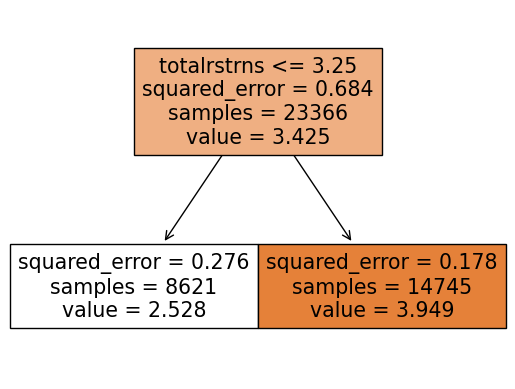

In [424]:
star_fig = plt.figure()
star_fig = tree.plot_tree(star_tree, feature_names=['totalrstrns', 'logtotalreviews','logpercentage', 'incomebill', 'firstmarravg'], filled=True)

Above is a regression tree that accounts for the variables included in the linear regression such as the number of restaurants, number of reviews, percentage of restuarants with ratings above 4.5, and the personal income and median age of first marraige in a state. This model has been pruned

The general form of the objective function for regression trees is:


$$
\min_{tree \subset T} \sum (\hat{f}(x)-y)^2 + \alpha|\text{terminal
   nodes in tree}|
$$

The regularization parameters of this model are the minimum leaf size, maximum tree depth, and the pruning parameter $ \alpha.


In the objective function:
- The summation portion on the left of the addition sign contains the error.
- The alpha is the tuning parameter which functions as a penalty for the complexity of terminal nodes. Therefore, the larger the $ \alpha $, the greater the penalty for a large tree. 
- The absolute value contains the number of terminal nodes which are penalized by the $ \alpha $ term.

For this particular pruned regression tree, the objective function is:

$$
0.2145 + 0.1|\text{2}|
$$


## Conclusion

From this extensive review on Yelp restaurants and their data, the attributes for location, category, and user interaction were analyzed to draw correlations with the rating a restaurant may receive. Location was analyzed at the state and city level. At the state level, the findings concluded that on average, states in the United States of America tend to have similar restaurant ratings of around 3.5 Yelp stars. This was lower than the only reported state outside of the United States, which was located in Canada and reported an average restaurant rating of about 4.0 Yelp stars. This finding stands out because of this difference in restaurant ratings according to the country, however, it requires more elaborate data because more states outside of the United States should be included in this analysis to make conclusive findings. At the city level, the findings concluded that restaurants in cities located in North America tend to receive similar ratings. These ratings were, on average, lower than those of the reported restaurants in cities that were located in Europe. From this analysis, it can be concluded that there is some relation between the location of a restaurant and the rating it may receive, but the dataset lacked restaurants represented in locations outside of the Americas. The category a restaurant is associated with was also analyzed, and the findings illustrated how there may be a correlation between the types of food served and the expected restaurant rating. For example, the 'Fast Food' category received lower ratings, on average, and the 'Burger' category which can be associated with fast food, also received lower ratings, on average, than the other categories accounted for. This analysis leaves possible explanations for the quality of food served in restaurants which fall under these categories, or whether the critique for these categories is stronger. Lastly, user interaction and restaurant ratings were analyzed. The number of reviews a restaurant received reflected interesting findings where restaurants with fewer reviews were more likely to receive ratings around 3.5 Yelp stars. However, as restaurants received more reviews, analysis reflected that there were more fluctuations in the average reviews restaurants received. This may be due to the true quality of the restaurant being illustrated in the data, or there may not have been enough restaurants with that specific review count recorded, and the fluctuation points may be outliers due to not enough data collected. Lastly, the amount of Yelp check-ins a restaurant receives was analyzed alongside its average rating. The data reflected a skewness towards a higher rating of about 4.0 Yelp stars for restaurants with more reviews. This could be due to people being more willing to use the check-in feature when they are at a restaurant they consider good.

To further this analysis, restaurants in the US were compared on the state level based on geographic location and distribution of restaurants which reflected the impact of competition on the quality of restaurants. In a scatterplot for the ratings of restaurants based on the state they are from, the number of restaurants in the state, there did seem to be a weak positive correlation between the number of restaurants in the state and the rating they received, however, more data points or analysis at a smaller scale may provide stronger results. In two density heatmaps of restaurants and their Yelp ratings, the visualizations provided evidence that in densely populated areas of restaurants, the ratings of restaurants are higher and that these dense clusters tend to appear around major cities.

Through the implementation of merging the Yelp Dataset with external datasets, underlying socioeconomic factors in the different US states can be accounted for across the different US states. Through the US Personal Income dataset, the theory of whether income is an indicator of the quality of restaurants was visualized. A thematic US map at the state level and suggested that there is some positive correlation between income and the quality of restaurants, as reflected in the average rating of restaurants in each state. This conclusion seems logical as regions with wealthier individuals may have a greater demand for quality restaurants. From the US Census Bureau, data regarding the median age of first marriage in the US states was extracted and merged with the Yelp Dataset. According to the thematic map, there appeared to be a positive correlation between later ages of first marriage and higher restaurant ratings in the US. This finding leads to the plausible conclusion that regions where people become married later may have a greater demand for quality restaurants. Additionally, data regarding the average family size across US states from the US Census Bureau was merged with the Yelp Dataset. A scatterplot visualization between the average restaurant rating and ratio of restaurants receiving ratings above 4.5 revealed a curvilinear relationship between family size and ratio of above average restaurants. This finding is particularly intriguing because there seems to be additional underlying factors to why people in certain regions choose to have a particular family size, and provides room for further analysis as to why states with the smallest and largest family sizes, on average, contain restaurants with a greater ratio of above average establishments.

Some limitations of the current analysis include a lack of data for certain attributes that were analyzed. For example, the restaurants reported were mainly based in North America, so it would be difficult to make more worldly conclusions of restaurant ratings in different countries. Additionally, more generalizing for summarizing data would possibly make the analysis more effective, especially when analyzing the number of reviews. These could have been grouped in multiples of 50s rather than the exact review value because then certain points would not be reflective of groups of restaurants, but rather only one restaurant. For the analysis of restaurants in the US, the data was limited to a state level and this may have prevented the creation of a full picture of the actual trends of restaurant quality and the variables observed. In the future, this should be expanded at a smaller scale such as at the county or city level so that more data points can be compared. Alternatively, data from more states could result in stronger conclusions especially when drawing conclusions regarding the socioeconomic status of people in different states.

Some future steps would be accounting for the limitations described, and further condensing the grouping of the data to form visualizations and conclusions at smaller geographic levels. Analysis to explore the correlation between restaurant business hours and their ratings as well as how individual users tend to rate restaurants would be interesting in creating a more holistic picture of the factors which compose a Yelp restaurant review because the types of reviewers and their standards have not been considered. Additionally, the search for more income-related correlations apart from age of marriage and family size on the quality of restaurants would be expanded upon because the current findings suggest some relation where more convincing factors may be at play.

# Citations

Bea.gov. “BEA Interactive Data Application,” 2023. https://apps.bea.gov/iTable/?reqid=70&step=1&acrdn=2#eyJhcHBpZCI6NzAsInN0ZXBzIjpbMSwyNCwyOSwyNSwzMSwyNiwyNywzMCwzMF0sImRhdGEiOltbIlRhYmxlSWQiLCIxMDAiXSxbIkNsYXNzaWZpY2F0aW9uIiwiTm9uLUluZHVzdHJ5Il0sWyJNYWpvcl9BcmVhIiwiMCJdLFsiU3RhdGUiLFsiMCJdXSxbIkFyZWEiLFsiWFgiXV0sWyJTdGF0aXN0aWMiLCIxIl0sWyJVbml0X29mX21lYXN1cmUiLCJMZXZlbHMiXSxbIlllYXIiLFsiMjAyMSJdXSxbIlllYXJCZWdpbiIsIi0xIl0sWyJZZWFyX0VuZCIsIi0xIl1dfQ==.

Cooper, C. (2019, July 3). Yelp Fact Sheet (The Good, Bad & Ugly). Rising Star Reviews. https://risingstarreviews.com/yelp-ratings/yelp-fact-sheet/#:~:text=small%20business%20sales.-,Your%20business%20needs%204.5%20or%205%20stars%20on%20Yelp%20just,rating%20of%204.5%20or%205.0.

Understanding and Using American Community Survey Data. (n.d.). https://www.census.gov/content/dam/Census/library/publications/2020/acs/acs_researchers_handbook_2020.pdf

U.S. Census Bureau. (2023). Explore Census Data. Census.gov. https://data.census.gov/table?q=DP02:+SELECTED+SOCIAL+CHARACTERISTICS+IN+THE+UNITED+STATES&t=Household+Size+and+Type&g=010XX00US,$0400000&y=2021&tid=ACSDP1Y2021.DP02

U.S. Census Bureau. (2023). Explore Census Data. Census.gov. https://data.census.gov/table?t=Marital+Status+and+Marital+History&g=010XX00US$0400000_040XX00US17,32,37,39,42,45,55&d=ACS+1-Year+Estimates+Detailed+Tables&tid=ACSDT1Y2021.B12007


US Census Bureau. “SAIPE State and County Estimates for 2016.” Census.gov, February 2, 2021. https://www.census.gov/data/datasets/2016/demo/saipe/2016-state-and-county.html.
‌

‌Yelp, Inc. “Yelp Dataset.” Kaggle.com, 2022. https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset.

‌
‌
